# Acts 20 and 22: Assessing the Effectiveness of Fiscal Incentives in Puerto Rico 
## Introduction
### Summary
This notebook contains the relevant Python code for replicating the results in "Acts 20 and 22: Assesing the Effectiveness of Fiscal Incentives in Puerto Rico", an undergraduate thesis by Cristian Bernaschina-Guillermety at the Wharton School of the University of Pennsylvania.

For more information, please reach out to Cristian Bernaschina-Guillermety at cbernasc@wharton.upenn.edu or cristianandres02@gmail.com (post-May 2022).
### Instructions
Please see the "Read Me" file for an in-depth description on how to use this notebook.

## Environment Setup

In [1]:
# PACKAGE IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os
import sys
from linearmodels import PooledOLS
from linearmodels.panel import PanelOLS, compare
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import mstats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import copy
from stargazer.stargazer import Stargazer, LineLocation

# PANDAS SETTINGS
pd.set_option('mode.chained_assignment', None)  # Suppress warnings when editing columns

# MATPLOTLIB SETTINGS
plt.style.use('ggplot')                         # Set visualization style

# PATHS
out = "../data/cleaned/"                        # Output data path

In [2]:
# DEFINE HELPER FUNCTIONS

def pr_assign(fips):
    """Assigns units of observation to Puerto Rico on the basis of their FIPS code"""
    if fips < 72999 and fips>72000:
        return 1
    else:
        return 0
    
def period_assign(year):
    """Assigns units of observation to pre/post intervention periods, relative to the introduction of 
    Acts 20 and 22 in January 2012"""
    if year<=2011:
        return 0
    else:
        return 1

## Panel Preparation

This section is commented out since you do not need to run it: **the balanced panel with all relevant variables used in the analysis is included in the replication folder**. However, this section helps you understand how the variables were created and the panel was balanced.

**If you are going to run this rection**, download raw, QCEW annual single-files for 2005 to 2016 from: https://www.bls.gov/cew/downloadable-data-files.htm and **save them in** `../data/raw/qcew`

### Consolidating QCEW Data
The files created below exclusively contain QCEW data. No variables are created nor are the dataframes contained in this section balanced.

In [3]:
# # PREPARING FOR FILE READING

# path = "../data/raw/qcew/"                         # Define location of raw QCEW annual files (contains annual QCEW data
#                                                    # from 2005 - 2016)
           
# file_names = sorted(os.listdir(path))              # Save file names located in path
       
# full_paths = []                                    # Empty list to save full paths to files

# for i in np.arange(0,len(file_names)):             # Loop through all the file names
#     full_path = str(path)+str(file_names[i])       # Create and save path of files to be read
#     full_paths.append(full_path)                   # Append to list to be read

#### 2-Digit NAICS File

In [4]:
# # HELPER FUNCTIONS
# def two_digit_func(code):
#     """ There are NAICS code at the two-digit level that consist of range values.
#         For ease of analysis, these are re-coded to exclusively consist of the first two integers"""
    
#     code_str = str(code)           # Convert the NAICS code into a string
#     code_shortened = code_str[:2]  # Slice and keep only the first two characters of code_str
#     code_int = int(code_shortened) # Convert the shortened code into an integer
#     return code_int


# # READING IN FILES AND PREPARING TO MERGE

# # Define columns to be kept from the raw QCEW annual file
# cols_to_keep = ['area_fips', 'own_code', 'industry_code',
#                'year', 'annual_avg_estabs','annual_avg_emplvl', 'total_annual_wages']

# # Define two-digit NAICS codes that consist of a range
# range_naics = ['31-33', '44-45', '48-49']

# # Define list to save annual, cleaned two-digit NAICS dataframes to be merged
# data_list_2_dig = []

# # Loop through all the annual QCEW files
# for i in np.arange(0,len(full_paths)):
    
#     # Read data from path
#     yearly_data = pd.read_csv(full_paths[i], low_memory=False)
    
#     # Exclusively keep columns defined in columns to keep
#     selected_cols = yearly_data[cols_to_keep]
    
#     # Select observations which either (1) have an industry code length of two, or (2) are in the range_naics list
#     data_2_digit = selected_cols[(np.logical_or(selected_cols['industry_code'].str.len() == 2, 
#                                         selected_cols['industry_code'].isin(range_naics)))]

#     # Keep only private data
#     data_2_digit = data_2_digit.query('own_code == 5')
    
#     # Ensure all industry_codes are re-coded to consist of two-digit integers
#     data_2_digit['industry_code'] = data_2_digit['industry_code'].apply(two_digit_func)
    
#     # Drop industry=summmary observations to avoid double counting
#     data_2_digit = data_2_digit.query('industry_code != 10')

#     # Drop unknown and state-level observations
#     data_2_digit = (data_2_digit[~(data_2_digit['area_fips'].astype(str).str.contains('999'))]
#                     .reset_index(drop=True)) # 999 = Unknown
#     data_2_digit = (data_2_digit[~(data_2_digit['area_fips'].astype(str).str.contains('000'))]
#                     .reset_index(drop=True)) # 000 = State Level
    
#     # Append cleaned, yearly dataframe to list
#     data_list_2_dig.append(data_2_digit)
    
#     # Clear variables to save space
#     del(yearly_data,selected_cols,data_2_digit)
    
# # Merge all two-digit annual files
# consolidated_2_dig_df = pd.concat(data_list_2_dig, ignore_index = True)

# # CLEANING DATAFRAME

# """There are a number of observations included in QCEW which are not counties (e.g. MicroSA / National data).
#    We leverage the fact that these have non-integer codes to drop these."""

# str_fips_index = []                      # Empty list to save indeces of non-counties
# str_fips_name = []                       # Empty list to save names of non-counties

# # Loop through all area_fips

# for i in np.arange(0,len(consolidated_2_dig_df['area_fips'])):
#     try:
#         int(consolidated_2_dig_df['area_fips'][i])                   # Check if FIPS is integer / county
#     except:
#         str_fips_index.append(i)                                     # Save index if non-integer / non-county
        
# # Drop non-numeric / non-county FIPS
# consolidated_2_dig_df = consolidated_2_dig_df.drop(str_fips_index, axis=0)

# # Convert numeric / county FIPS into integers
# consolidated_2_dig_df['area_fips'] = consolidated_2_dig_df['area_fips'].apply(int)

# # [Uncomment lines below] Export file
# output_file_2_dig = os.path.join(out,'qcew_2_dig.csv')
# consolidated_2_dig_df.to_csv(output_file_2_dig, index=False)

#### County-Summary File

In [5]:
# # Define columns to be kept from the raw QCEW annual file
# cols_to_keep = ['area_fips', 'own_code', 'industry_code', 
#                'year', 'annual_avg_estabs','annual_avg_emplvl', 'total_annual_wages']

# # Define list to save annual, cleaned county-summary dataframes to be merged
# data_list_county_summary = []

# # Loop through all annual file paths
# for i in np.arange(0,len(full_paths)):
    
#     # Read file
#     yearly_data = pd.read_csv(full_paths[i], low_memory=False)
    
#     # Keep selected columns
#     selected_cols = yearly_data[cols_to_keep]
    
#     # Exclusively select observations where industry_code = 10 (summary-level)
#     yearly_county_summ = selected_cols[selected_cols['industry_code']=='10']
    
#     # Only keep private data
#     yearly_county_summ = yearly_county_summ.query('own_code == 5')

#     # Drop unknown and state-level observations
#     yearly_county_summ = (yearly_county_summ[~(yearly_county_summ['area_fips'].astype(str).str.contains('999'))]
#                     .reset_index(drop=True)) # 999 = Unknown
#     yearly_county_summ = (yearly_county_summ[~(yearly_county_summ['area_fips'].astype(str).str.contains('000'))]
#                     .reset_index(drop=True)) # 000 = State Level
    
#     # Convert all industry_codes to integers
#     yearly_county_summ['industry_code'] = yearly_county_summ['industry_code'].apply(int)
    
#     # Append yearly data frame to list
#     data_list_county_summary.append(yearly_county_summ)
    
#     # Clear files to save space
#     del(yearly_data,selected_cols,yearly_county_summ)

    
# # Merge yearly files
# consolidated_county_summ_df = pd.concat(data_list_county_summary, ignore_index = True)


# # DATA CLEANING

# """There are a number of observations included in QCEW which are not counties (e.g. MicroSA / National data).
#    We leverage the fact that these have non-integer codes to drop these."""

# str_fips_index = []                      # Empty list to save indeces of non-counties
# str_fips_name = []                       # Empty list to save names of non-counties

# # Loop through all area_fips

# for i in np.arange(0,len(consolidated_county_summ_df['area_fips'])):   
#     try:                                  
#         int(consolidated_county_summ_df['area_fips'][i])    # Check if FIPS is integer / county
#     except:
#         str_fips_index.append(i)                            # Save index if non-integer / non-county
        
# # Drop non-numeric / non-county FIPS
# consolidated_county_summ_df = consolidated_county_summ_df.drop(str_fips_index, axis=0).reset_index(drop=True)

# # Convert county FIPS to integers
# consolidated_county_summ_df['area_fips'] = consolidated_county_summ_df['area_fips'].apply(int)

# # [Uncomment lines below] Export file
# out_county_summ = os.path.join(out,'qcew_county_summ.csv')
# consolidated_county_summ_df.to_csv(out_county_summ, index=False)

#### State-Level File (2-Digit)

In [6]:
# # HELPER FUNCTIONS
# def two_digit_func(code):
#     """ There are NAICS code at the two-digit level that consist of range values.
#         For ease of analysis, these are re-coded to exclusively consist of the first two integers"""
    
#     code_str = str(code)           # Convert the NAICS code into a string
#     code_shortened = code_str[:2]  # Slice and keep only the first two characters of code_str
#     code_int = int(code_shortened) # Convert the shortened code into an integer
#     return code_int


# # READING IN FILES AND PREPARING TO MERGE

# # Define columns to be kept from the raw QCEW annual file
# cols_to_keep = ['area_fips', 'own_code', 'industry_code',
#                'year', 'annual_avg_estabs','annual_avg_emplvl', 'total_annual_wages']

# # Define two-digit NAICS codes that consist of a range
# range_naics = ['31-33', '44-45', '48-49']

# # Define list to save annual, cleaned two-digit NAICS dataframes to be merged
# data_list_state_2dig = []

# # Loop through all the annual QCEW files
# for i in np.arange(0,len(full_paths)):
    
#     # Read data from path
#     yearly_data = pd.read_csv(full_paths[i], low_memory=False)
    
#     # Exclusively keep columns defined in columns to keep
#     selected_cols = yearly_data[cols_to_keep]
    
#     # Select observations which either (1) have an industry code length of two, or (2) are in the range_naics list
#     data_state_2dig = selected_cols[(np.logical_or(selected_cols['industry_code'].str.len() == 2, 
#                                         selected_cols['industry_code'].isin(range_naics)))]

#     # Keep only private data
#     data_state_2dig = data_state_2dig.query('own_code == 5')
    
#     # Ensure all industry_codes are re-coded to consist of two-digit integers
#     data_state_2dig['industry_code'] = data_state_2dig['industry_code'].apply(two_digit_func)
    
#     # Drop industry=summmary observations to avoid double counting
#     data_state_2dig = data_state_2dig.query('industry_code != 10')

#     # Exclusively keep state-level observations
#     data_state_2dig = (data_state_2dig[(data_state_2dig['area_fips'].astype(str).str.contains('000'))]
#                     .reset_index(drop=True)) # 000 = State level
    
#     # Append cleaned, yearly dataframe to list
#     data_list_state_2dig.append(data_state_2dig)
    
#     # Clear variables to save space
#     del(yearly_data,selected_cols,data_state_2dig)
    
# # Merge all two-digit annual files
# consolidated_state_2dig_df = pd.concat(data_list_state_2dig, ignore_index = True)

# # CLEANING DATAFRAME

# """There are a number of observations included in QCEW which are not counties (e.g. MicroSA / National data).
#    We leverage the fact that these have non-integer codes to drop these."""

# str_fips_index = []                      # Empty list to save indeces of non-counties
# str_fips_name = []                       # Empty list to save names of non-counties

# # Loop through all area_fips

# for i in np.arange(0,len(consolidated_state_2dig_df['area_fips'])):
#     try:
#         int(consolidated_state_2dig_df['area_fips'][i])                   # Check if FIPS is integer / county
#     except:
#         str_fips_index.append(i)                                     # Save index if non-integer / non-county
        
# # Drop non-numeric / non-county FIPS
# consolidated_state_2dig_df = consolidated_state_2dig_df.drop(str_fips_index, axis=0)

# # Convert numeric / county FIPS into integers
# consolidated_state_2dig_df['area_fips'] = consolidated_state_2dig_df['area_fips'].apply(int)

# # [Uncomment lines below] Export file
# output_file_state_2dig = os.path.join(out,'qcew_state_2dig.csv')
# consolidated_state_2dig_df.to_csv(output_file_state_2dig, index=False)

#### State-Level (4-Digit NAICS)

In [7]:
# # HELPER FUNCTIONS
# def two_digit_func(code):
#     """ There are NAICS code at the two-digit level that consist of range values.
#         For ease of analysis, these are re-coded to exclusively consist of the first two integers"""
    
#     code_str = str(code)           # Convert the NAICS code into a string
#     code_shortened = code_str[:2]  # Slice and keep only the first two characters of code_str
#     code_int = int(code_shortened) # Convert the shortened code into an integer
#     return code_int


# # READING IN FILES AND PREPARING TO MERGE

# # Define columns to be kept from the raw QCEW annual file
# cols_to_keep = ['area_fips', 'own_code', 'industry_code',
#                'year', 'annual_avg_estabs','annual_avg_emplvl', 'total_annual_wages']

# # Define two-digit NAICS codes that consist of a range
# range_naics = ['31-33', '44-45', '48-49']

# # Define list to save annual, cleaned two-digit NAICS dataframes to be merged
# data_list_state_4dig = []

# # Loop through all the annual QCEW files
# for i in np.arange(0,len(full_paths)):
    
#     # Read data from path
#     yearly_data = pd.read_csv(full_paths[i], low_memory=False)
    
#     # Exclusively keep columns defined in columns to keep
#     selected_cols = yearly_data[cols_to_keep]
    
#     # Select observations which have an industry code length of four
#     data_state_4dig = selected_cols[selected_cols['industry_code'].str.len() == 4] 

#     # Keep only private data
#     data_state_4dig = data_state_4dig.query('own_code == 5')
    
    
#     # Drop industry=summmary observations to avoid double counting
#     data_state_4dig = data_state_4dig.query('industry_code != 10')

#     # Exclusively keep state-level observations
#     data_state_4dig = (data_state_4dig[(data_state_4dig['area_fips'].astype(str).str.contains('000'))]
#                     .reset_index(drop=True)) # 000 = State level
    
#     # Append cleaned, yearly dataframe to list
#     data_list_state_4dig.append(data_state_4dig)
    
#     # Clear variables to save space
#     del(yearly_data,selected_cols,data_state_4dig)
    
# # Merge all two-digit annual files
# consolidated_state_4dig_df = pd.concat(data_list_state_4dig, ignore_index = True)

# # CLEANING DATAFRAME

# """There are a number of observations included in QCEW which are not counties (e.g. MicroSA / National data).
#    We leverage the fact that these have non-integer codes to drop these."""

# str_fips_index = []                      # Empty list to save indeces of non-counties
# str_fips_name = []                       # Empty list to save names of non-counties

# # Loop through all area_fips

# for i in np.arange(0,len(consolidated_state_4dig_df['area_fips'])):
#     try:
#         int(consolidated_state_4dig_df['area_fips'][i])                   # Check if FIPS is integer / county
#     except:
#         str_fips_index.append(i)                                     # Save index if non-integer / non-county
        
# # Drop non-numeric / non-county FIPS
# consolidated_state_4dig_df = consolidated_state_4dig_df.drop(str_fips_index, axis=0)

# # Convert numeric / county FIPS into integers
# consolidated_state_4dig_df['area_fips'] = consolidated_state_4dig_df['area_fips'].apply(int)

# # [Uncomment lines below] Export file
# output_file_state_4dig = os.path.join(out,'qcew_state_4dig.csv')
# consolidated_state_4dig_df.to_csv(output_file_state_4dig, index=False)

### Population Data
We create dataframes containing population data from the US Census's Population Estimates Program.

Raw data is provided in `../data/raw/pop` and the cleaned data prepared in this section is located in `../data/cleaned`

In [8]:
# # HELPER FUNCTIONS

# def get_fips(geo_id):
#     """This function is exclusively used on the 2010 - 2019 population data and extracts the area_fips from
#        the geo_id column (a string). It returns the area_fips as an integer"""
#     fips = geo_id[9:]
#     return int(fips)

# def get_year(date_code):
#     """This function cleans the year column and extracts the year variables."""
#     year = date_code.replace(' ', '/').split('/')[2]
#     return int(year)

# def get_fips_summ(geo_id):
#     """This function converts the geo_id into state-level FIPS codes when relevant."""
#     fips = int(geo_id[9:])*1000
#     return fips

In [9]:
# # STATEWIDE 2000 - 2010 DATA (intercensal estimates for july in each year)

# # Read data
# state_2000 = pd.read_csv('../data/raw/pop/state-intercensal-2000-2010.csv', low_memory=False, encoding='latin-1')

# # Creating area_fips column based on state and county identifiers 
# state_2000['area_fips'] = state_2000['STATE']*1000 + state_2000['COUNTY']

# # Select cols to keep
# state_2000 = state_2000[['area_fips','POPESTIMATE2000', 'POPESTIMATE2001',
#        'POPESTIMATE2002', 'POPESTIMATE2003', 'POPESTIMATE2004',
#        'POPESTIMATE2005', 'POPESTIMATE2006', 'POPESTIMATE2007',
#        'POPESTIMATE2008', 'POPESTIMATE2009', 'POPESTIMATE2010']]

# # Rename the columns with year 
# for col in state_2000.columns[1:]:                   # Loop over all columns except area fips
#     yr = int(col[-4:])                               # Extract year from column name
#     state_2000 = state_2000.rename(columns={col:yr}) # Rename the column

# """The  dataframe has one row per county and one column per year.
#    For ease of merging, I melt this dataframe, so as to have one row per each county-year observation"""
    
# state_2000 = (pd.melt(state_2000 ,id_vars=['area_fips'],value_name='pop')  # Melting the dataframe
#               .rename(columns={'variable' : 'year'}))                      # Rename

# # Drop intercensal estimate to use census data instead
# state_2000 = state_2000.query('year != 2010').reset_index(drop=True)

# # PUERTO RICO 2000 - 2009 DATA
# """The data for 2000 to 2010 for Puerto Rico is not included in the state-wide file for this period, 
# and has to be added separately."""

# # Read file
# pr_2000 = pd.read_csv('../data/raw/pop/pr-intercensal-2000-2010.csv', low_memory=False)

# # Melting dataframe, per description above
# pr_2000 = (pd.melt(pr_2000,id_vars=['County Name','area_fips'],value_name='pop') # Melting                           # For ease of visibility, sort by fips and year
#            .rename(columns={'County Name' : 'county_name', 'variable' : 'year'}) # Renaming columns
#            .sort_values(by=['area_fips', 'year']))                               # Sort for ease of visibility

# # Convert year to int
# pr_2000['year'] = pr_2000['year'].astype(int)

# # Reorder columns
# pr_2000 = pr_2000[['area_fips', 'year', 'pop']]

# # Drop 2010 data to avoid duplicates; 2010 will be used from census estimate
# pr_2000 = pr_2000.query('year != 2010')

# # COUNTY-LEVEL 2010 - 2019

# # Read data, ignore first col since it is variable description and not data
# county_2010 = pd.read_csv('../data/raw/pop/pep-2010-2019.csv', low_memory=False, encoding='latin-1').loc[1:]

# # Data cleaning
# county_2010['area_fips'] = county_2010['GEO_ID'].apply(get_fips)   # Get area fips from geoid

# county_2010['year'] = county_2010['DATE_CODE'].apply(get_year)     # Get year from datecode

# county_2010 = (county_2010[np.logical_or(
#                             # Include the 2010 Census population data
#                             county_2010['DATE_CODE'].str.contains('Census population'),

#                             # Exclude 2010 "population estimates base"
#                             county_2010['year']!=2010)])        
               
# county_2010 = county_2010[['area_fips', 'year', 'POP']]                           # Columns to keep
# county_2010 = county_2010.rename(columns={'POP' : 'pop'}).reset_index(drop=True)  # Rename

# # STATE-LEVEL 2010 - 2019 

# # Read data, ignore first col since it is variable description and not data
# state_summ_2010 = pd.read_csv('../data/raw/pop/pep-2010-2019-stateonly.csv', low_memory=False, encoding='latin-1').loc[1:]

# # Data cleaning
# state_summ_2010['area_fips'] = state_summ_2010['GEO_ID'].apply(get_fips_summ) # Get area fips from geoid

# state_summ_2010['year'] = state_summ_2010['DATE_CODE'].apply(get_year)        # Get year from datecode

# state_summ_2010 = (state_summ_2010[np.logical_or(
#                             # Include the 2010 Census population data
#                             state_summ_2010['DATE_CODE'].str.contains('Census population'),
    
#                             # Exclude 2010 "population estimates base"    
#                             state_summ_2010['year']!=2010)])
# state_summ_2010 = state_summ_2010[['area_fips', 'year', 'POP']]                          # Columns to keep
# state_summ_2010 = state_summ_2010.rename(columns={'POP' : 'pop'}).reset_index(drop=True) # Rename

# # MERGING DATAFRAMES
# pop = (pd.concat([state_2000, pr_2000, county_2010, state_summ_2010],ignore_index=True)
#        .reset_index(drop=True)
#        .sort_values(by=['area_fips','year']).reset_index(drop=True))

# # [Uncomment lines below] Export file
# output_file_pop = os.path.join(out,'pop.csv')
# pop.to_csv(output_file_pop, index=False)

### Panel Creation and Balancing

#### Loading and preparing data

In [10]:
# # Loading data
# county_summ_df = pd.read_csv('../data/cleaned/qcew_county_summ.csv', low_memory=False,encoding='latin-1')
# county_industry_df = pd.read_csv('../data/cleaned/qcew_2_dig.csv', low_memory=False,encoding='latin-1')
# pop = pd.read_csv('../data/cleaned/pop.csv')

# #Create area-industries
# county_industry_df['area_industry'] = (county_industry_df['area_fips'].astype(str) + '-' 
#                                        + county_industry_df['industry_code'].astype(str))

# #Add dummies for being in Puerto Rico
# county_industry_df['pr_dummy'] = county_industry_df['area_fips'].apply(pr_assign)
# county_summ_df['pr_dummy'] = county_summ_df['area_fips'].apply(pr_assign)

# #Add dummy if after treatment
# county_industry_df['time_dummy'] = county_industry_df['year'].apply(period_assign)
# county_summ_df['time_dummy'] = county_summ_df['year'].apply(period_assign)

# #Create time-industries
# county_industry_df['time_industry'] = ((county_industry_df['year'].astype(str) + 
#                                        county_industry_df['industry_code'].astype(str)).astype(int))

# # Add population data
# county_industry_df = pd.merge(county_industry_df, pop, how='left', on=['area_fips', 'year'])
# county_summ_df = pd.merge(county_summ_df, pop, how='left', on=['area_fips', 'year'])

#### County-Industry Panel

##### Balancing

In [11]:
# # Create copy of panel to work on and prepare panel
# panel = copy.deepcopy(county_industry_df)

# # DROPPING DATA FOR WHICH WE DO NOT HAVE ENTRIES ALL YEARS

# # Find area industries where there is not data for all years in the sample
# unique_ai, ai_counts = np.unique(panel['area_industry'],return_counts=True)
# inc_area_inds = unique_ai[ np.argwhere(ai_counts!=12).reshape(-1) ]

# # Cross check against area-industries with missing entries and drop 
# panel = (panel[np.invert(
#                         panel['area_industry'].isin(inc_area_inds))].reset_index(drop=True))

# # DROPPING OMISSIONS IN DEPENDENT VARIABLES

# # Define dependent variable columns to check for 0 values
# outcome_cols = ['annual_avg_estabs', 'annual_avg_emplvl','total_annual_wages']

# # List for area_industries to be dropped
# ai_drops = []

# # Loop through the data-set to find which area industries have 0 in any of the DV columns
# for obs in np.arange(0,len(panel['area_industry'])):
#     for col in outcome_cols:
#         if panel[col][obs] == 0:
#             to_drop = panel['area_industry'][obs]
#             ai_drops.append(to_drop)

# # Drop all area-industries with 0 in any of those columns
# panel = panel[np.invert(panel['area_industry'].isin(ai_drops))].reset_index(drop=True)
            
# # Search for counties with missing population data
# naan_pops = np.unique(panel[panel['pop'].isnull()]['area_fips'])

# # Drop counties with naan populations in any year
# panel = panel[np.invert(panel['area_fips'].isin(naan_pops))].reset_index(drop=True)

##### Per Capita Variable Creation

In [12]:
# # CREATING PER CAPITA DATA IN COUNTY_INDUSTRY DF

# #Define columns to scale
# cols_to_scale = ['annual_avg_estabs', 'annual_avg_emplvl', 'total_annual_wages']
# dv_scaled_names = []

# #Create columns and scale by population
# for i in np.arange(0,len(cols_to_scale)):
#     colname = 'pc_' + cols_to_scale[i] # Add create per-capita column name 
#     dv_scaled_names.append(colname)    # Save column names
#     panel[colname] = (panel[cols_to_scale[i]]
#                                    /panel['pop'])          # Scale by population in county

##### Export

In [13]:
# # Reorder columns
# panel = panel[['area_fips', 'industry_code', 'year', 'area_industry', 
#                'time_industry' ,'pr_dummy', 'time_dummy', 'pop',
#                'annual_avg_estabs', 'annual_avg_emplvl', 'total_annual_wages',
#                'pc_annual_avg_estabs', 'pc_annual_avg_emplvl',
#                'pc_total_annual_wages']]


# # [Uncomment lines below] Export file
# output_panel = os.path.join(out,'panel.csv')
# panel.to_csv(output_panel, index=False)

#### County-Summary Panel

In [14]:
# # Load data
# county_summ_panel = copy.deepcopy(county_summ_df)

# # Balance county-summary panel so as to only include counties available in balanced county-industry panel
# county_summ_panel = county_summ_panel[np.isin(county_summ_panel['area_fips'], np.unique(panel['area_fips']))].reset_index(drop=True)

##### County-Summary Ommissions
There are counties for which we know there is employment information available (e.g. appears in 2-digit file) but for which data at the county-summary level is ommitted. Given that our panel is balanced, we can reconstruct these variables with a high degree of accuracy using the balanced 2-digit panel.

In [15]:
# #Calculate implied data values for each county by the county-industry df
# implied_data_df = (panel
#                      .groupby(['area_fips', 'year']) # Unit of observation
#                      ['annual_avg_estabs', 'annual_avg_emplvl', 'total_annual_wages'] #DV of interest
#                      .agg(['sum']).reset_index(drop=False)) # Aggregate by summing

# #Find where annual_avg_emplvl are ommited
# mask = np.argwhere(np.array(county_summ_panel['annual_avg_emplvl'] == 0)).reshape(-1)

# for i in mask:
#     area_fips = county_summ_panel.loc[i]['area_fips'] #Find location
    
#     year = county_summ_panel.loc[i]['year'] #Find year
    
#     #Find implied value
#     implied_obs = implied_data_df[np.logical_and(implied_data_df['year'] == year, implied_data_df['area_fips'] == area_fips)].reset_index(drop=True)
    
#     #Save in dataframe
#     county_summ_panel.at[i,'annual_avg_emplvl'] = implied_obs['annual_avg_emplvl']['sum'][0]
    
# #Find where total_annual_wages are ommited
# mask = np.argwhere(np.array(county_summ_panel['total_annual_wages'] == 0)).reshape(-1)

# for i in mask:
#     area_fips = county_summ_panel.loc[i]['area_fips'] #Find location
    
#     year = county_summ_panel.loc[i]['year'] #Find region
    
#     #Find implied value
#     implied_obs = implied_data_df[np.logical_and(implied_data_df['year'] == year, implied_data_df['area_fips'] == area_fips)].reset_index(drop=True)
    
#     #Save in dataframe
#     county_summ_panel.at[i,'total_annual_wages'] = implied_obs['total_annual_wages']['sum'][0]

##### Per-Capita Data

In [16]:
# # CREATING PER CAPITA DATA IN COUNTY_SUMMARY DF

# #Define columns to scale
# cols_to_scale = ['annual_avg_estabs', 'annual_avg_emplvl', 'total_annual_wages']
# dv_scaled_names = []

# #Create columns and scale by population
# for i in np.arange(0,len(cols_to_scale)):
#     colname = 'pc_' + cols_to_scale[i] # Add create per-capita column name 
#     dv_scaled_names.append(colname)    # Save column names
#     county_summ_panel[colname] = (county_summ_panel[cols_to_scale[i]]
#                                    /county_summ_panel['pop'])          # Scale by population in county

##### Industry Mix Data

In [17]:
# # Pull 2011 data
# data_2011 = panel.query('year == 2011').reset_index(drop=True)

# # Define unique counties in the balanced data set
# counties = np.unique(panel['area_fips'])

# # Create list for shares
# manuf_share = np.zeros(len(counties))     # NAICS = 31
# services_share = np.zeros(len(counties))  # NAICS = 54
# food_share = np.zeros(len(counties))      # NAICS = 72

# # Loop through all counties and get industry mixes
# for i in np.arange(len(counties)):
    
#     # Subset data for each county
#     county_2011_data = data_2011[data_2011['area_fips'] == counties[i]].reset_index(drop=True)
    
#     # Calculate industry shares, if industry is not present in county in 2011, fill with zero
#     try:
#         manuf_share[i] = (county_2011_data[county_2011_data['industry_code'] == 31].reset_index(drop=True)['annual_avg_emplvl'][0]
#                       / county_2011_data['annual_avg_emplvl'].sum())
#     except:
#         manuf_share[i] = 0
    
#     try:
#         services_share[i] = (county_2011_data[county_2011_data['industry_code'] == 54].reset_index(drop=True)['annual_avg_emplvl'][0]
#                       / county_2011_data['annual_avg_emplvl'].sum())
#     except:
#         services_share[i]= 0
    
#     try:
#         food_share[i] = (county_2011_data[county_2011_data['industry_code'] == 72].reset_index(drop=True)['annual_avg_emplvl'][0]
#                       / county_2011_data['annual_avg_emplvl'].sum())
#     except:
#         food_share[i] = 0
        
# # Create dataframe with each county's shares
# share_df = pd.DataFrame({'area_fips' : counties, 
#                          'manuf_share' : manuf_share, 
#                          'services_share' : services_share, 
#                          'food_share' : food_share})

# # Add shares to county-summary dataframe
# county_summ_panel = pd.merge(county_summ_panel, share_df, how='left', on=['area_fips'])

##### Growth Rates
Calculating growth rates in variables of interest over a number of time periods

In [18]:
# #Create a list of all counties
# counties = np.unique(county_summ_panel['area_fips'])

# #Define which variables you are interested in finding growth rates
# vars_of_interest = ['pc_annual_avg_estabs', 'pc_annual_avg_emplvl', 'pc_total_annual_wages']

# #Define periods for growth rates
# g_pds = ['g_2005_2011', 'g_2007_2011', 'g_2009_2011']

# #Create a dictionary in which to store growth rates
# g_dict = {'area_fips' : counties}

# #Create keys for all variables of interest in this dictionary
# for c in np.arange(len(vars_of_interest)):
#     for p in np.arange(len(g_pds)):
#         colname = g_pds[p] + '_' + vars_of_interest[c] 
#         g_dict[colname] = []
        
# for r in np.arange(len(counties)): #Go through all the counties
#     ai_panel = county_summ_panel[county_summ_panel['area_fips']==counties[r]] #Create panel for all of them
#     obs_2005 = ai_panel.query('year == 2005').reset_index(drop=True) #Pull 2005 data
#     obs_2007 = ai_panel.query('year == 2007').reset_index(drop=True) #Pull 2007 data
#     obs_2009 = ai_panel.query('year == 2009').reset_index(drop=True) #Pull 2009 data
#     obs_2011 = ai_panel.query('year == 2011').reset_index(drop=True) #Pull 2011 data
#     for c in np.arange(len(vars_of_interest)): #Go through all columns of interest
#         g_2005_2011 = obs_2011[vars_of_interest[c]][0]/obs_2005[vars_of_interest[c]][0] - 1 #Pd 1 g rate
#         g_2007_2011 = obs_2011[vars_of_interest[c]][0]/obs_2007[vars_of_interest[c]][0] - 1 #Pd 2 g rate
#         g_2009_2011 = obs_2011[vars_of_interest[c]][0]/obs_2009[vars_of_interest[c]][0] - 1 #Pd 3 g rate
        
#         g_dict['g_2005_2011_' + vars_of_interest[c]].append(g_2005_2011) #Append values to dictionary
#         g_dict['g_2007_2011_' + vars_of_interest[c]].append(g_2007_2011)
#         g_dict['g_2009_2011_' + vars_of_interest[c]].append(g_2009_2011)

# county_g_df = pd.DataFrame(g_dict)

# county_summ_panel = pd.merge(county_summ_panel, county_g_df, how='left', on=['area_fips'])

##### Export

In [19]:
# # Reorder columns
# county_summ_panel = county_summ_panel[['area_fips', 'industry_code', 'year','pr_dummy', 
#                                        'time_dummy', 'pop', 'manuf_share', 'services_share', 'food_share', 
#                                        'annual_avg_estabs', 'annual_avg_emplvl', 'total_annual_wages',
#                                        'pc_annual_avg_estabs', 'pc_annual_avg_emplvl', 'pc_total_annual_wages',
#                                         'g_2005_2011_pc_annual_avg_estabs', 'g_2007_2011_pc_annual_avg_estabs',
#                                        'g_2009_2011_pc_annual_avg_estabs', 'g_2005_2011_pc_annual_avg_emplvl',
#                                        'g_2007_2011_pc_annual_avg_emplvl', 'g_2009_2011_pc_annual_avg_emplvl',
#                                        'g_2005_2011_pc_total_annual_wages',
#                                        'g_2007_2011_pc_total_annual_wages',
#                                        'g_2009_2011_pc_total_annual_wages']]

# # [Uncomment lines below] Export file
# output_county_summ_panel = os.path.join(out,'county_summ_panel.csv')
# county_summ_panel.to_csv(output_county_summ_panel, index=False)

## Descriptive Visualizations

### Employment
The following visualizations are constructed from QCEW data at the 2-digit NAICS level.

#### Change by Industry 

In [20]:
# Read data
qcew_state_2dig = pd.read_csv('../data/cleaned/qcew_state_2dig.csv')

# Extract Puerto Rico data
pr = qcew_state_2dig.query('area_fips == 72000')

# Extract Puerto Rico data for 2011
pr_2011 = pr.query('year == 2011')

# Present five largest industries in 2011
print(pr_2011.sort_values(by='annual_avg_emplvl',ascending=False).head()[['industry_code', 'annual_avg_emplvl']])

# Set indeces for ease of accessing industry data by region chronologically
qcew_state_2dig = qcew_state_2dig.set_index(['industry_code', 'area_fips', 'year'])

       industry_code  annual_avg_emplvl
10253             44             128145
10251             31              82528
10262             62              79072
10260             56              69438
10264             72              68882


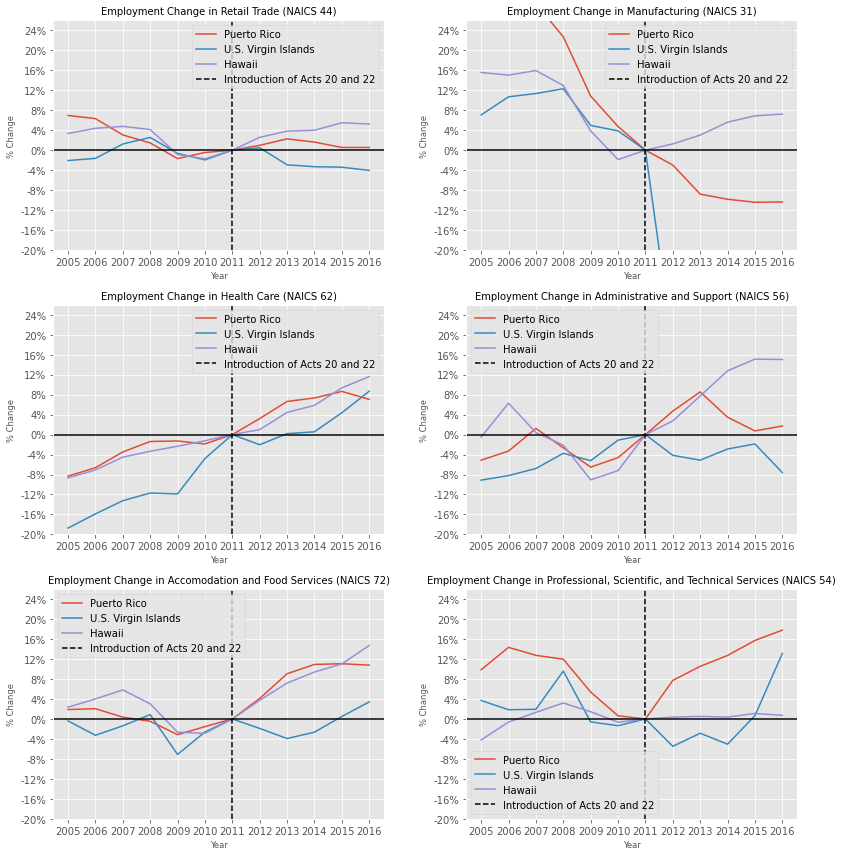

In [21]:
## VISUALIZATIONS

# Preparing labels
industry_codes = [44, 31, 62, 56, 72, 54]                       # Specify NAICS codes of interest
ind_name = ['Retail Trade', 'Manufacturing',                    # Specify labels for NAICS codes
            'Health Care', 'Administrative and Support', 
            'Accomodation and Food Services', 
            'Professional, Scientific, and Technical Services']

regions = (['Puerto Rico', 'U.S. Virgin Islands', 'Hawaii'])    # Specify regions of interest
regions_fips = ([72000, 78000, 15000])  # Specify FIPS code for regions of interest

# Create matplotlib subplots
fig,ax = plt.subplots(3,2, figsize=(12,12))
ax = ax.flatten()

# Loop over all industries and create a plot for each
for i, ind in enumerate(industry_codes):
    
    # Title for each industry
    ax[i].set_title('Employment Change in ' + ind_name[i] + 
                    ' (NAICS ' + str(ind) + ')', size='medium')
    
    # Get data for industry
    df = qcew_state_2dig.loc[ind]
    
    # Loop over regions of interest
    for r, region in enumerate(regions):
        
        # Locate data for the region in this industry
        r_df = df.loc[regions_fips[r]]
        
        # Convert employment level as % change from 2011 levels
        data = r_df['annual_avg_emplvl'] / r_df['annual_avg_emplvl'][2011] - 1
        
        # Plot data for each region
        ax[i].plot(data, label=region)
        
        
    # Formatting 
    ax[i].axvline(2011, color='k', label='Introduction of Acts 20 and 22', ls = '--')
    ax[i].axhline(0,color='k')
    ax[i].set_yticks(np.arange(-.20,.28,0.04))
    ax[i].set_ylim([-.20, .26])
    ax[i].set_xticks(np.arange(2005,2017))
    ax[i].set_ylabel('% Change', size='small')
    ax[i].set_xlabel('Year', size='small')
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax[i].legend()
    
fig.set_tight_layout(True)

#### Puerto Rico vs U.S.

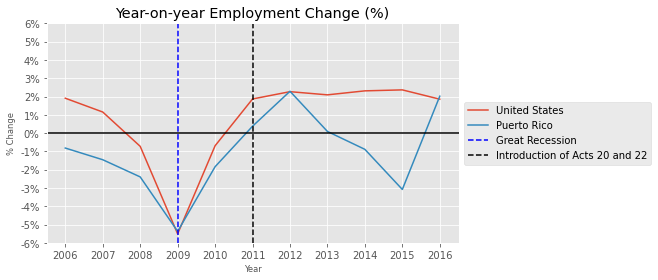

In [22]:
# Create copy of qcew state data
state = copy.deepcopy(qcew_state_2dig).reset_index(drop=False) 

state = (state.groupby(['area_fips', 'year'])  # Group all states together
         .agg({'annual_avg_emplvl' : 'sum'})   # Add up employment in all industries within each state
         .reset_index(drop=False))             # Reset index and keep both as columns for ease of plotting

state['pr'] = np.where(state['area_fips'] == 72000, 1, 0)                # Dummy variable for being in PR
state = state.groupby(['pr', 'year']).agg({'annual_avg_emplvl' : 'sum'}) # Add employment in PR and non-PR for all yrs

us_data = state.loc[0] # Extract non-PR US data
pr_data = state.loc[1] # Extract PR data

us_data['yoy_g'] = np.zeros(us_data.shape[0]) # List to save growth rates for USA

# Calculating year-on-year employment changes
for year in np.arange(2005,2017):                     # Loop through all years in our data
    if year == 2005:
        us_data.at[2005, 'yoy_g'] = np.NaN            # If 2005, fill with null since no prior year to reference
    else:
        us_data.at[year, 'yoy_g'] = (us_data.at[year, 'annual_avg_emplvl']   # Calculate growth rate in employment
                                     / us_data.at[year - 1,                  # For each year, relative to prior
                                                  'annual_avg_emplvl'] - 1)  # Employment level in the USA
        

pr_data['yoy_g'] = np.zeros(pr_data.shape[0])         

for year in np.arange(2005,2017):                     # Loop through all years in our data
    if year == 2005:
        pr_data.at[2005, 'yoy_g'] = np.NaN            # If 2005, fill with null since no prior year to reference
    else:
        pr_data.at[year, 'yoy_g'] = (pr_data.at[year, 'annual_avg_emplvl']    # Calculate growth rate in employment
                                     / pr_data.at[year - 1,                   # For each year relative to prior
                                                  'annual_avg_emplvl'] - 1)   # Employment level in PR
    
# Select years for which we have values
pr_data = pr_data.loc[np.arange(2006, 2017)]
us_data = us_data.loc[np.arange(2006, 2017)]

# VISUALIZATION

# Create matplotlib plot
fig, ax = plt.subplots(figsize = (8,4))

# Plot data
ax.plot(us_data['yoy_g'], label='United States')
ax.plot(pr_data['yoy_g'], label='Puerto Rico')

# Formatting
ax.set_title('Year-on-year Employment Change (%)')
ax.axhline(0, color='k')
ax.axvline(2009, color='b', label='Great Recession', ls = '--')
ax.axvline(2011, color='k', label='Introduction of Acts 20 and 22', ls = '--')
ax.set_yticks(np.arange(-.06,.07,0.01))
ax.set_xticks(np.arange(2006,2017))
ax.set_xlabel('Year', size='small')
ax.set_ylabel('% Change', size='small')

# Setting legend to the side
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Clean layout
fig.set_tight_layout(True)

### Taxes
The following data was retrieved from the Puerto Rico Department of Treasury website (http://www.hacienda.gobierno.pr/inversionistas/estadisticas-y-recaudos-statistics-and-revenues/ingresos-netos-al-fondo-general-general-fund-net-revenues).

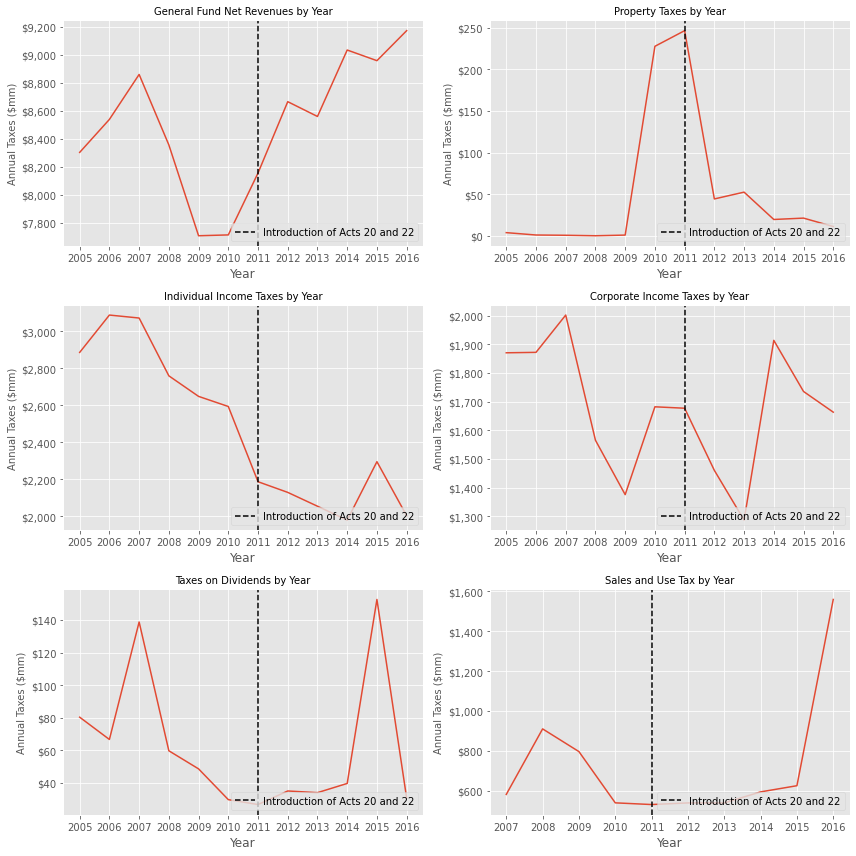

In [23]:
# INGESTING DATA

# Read file
tax_df = pd.read_csv('../data/raw/tax/taxes.csv').T.reset_index()

# Reset titles
tax_df.columns = tax_df.iloc[0]

# Drop "row" containing columns titles
tax_df = tax_df.iloc[1:13]

# Renaming, setting index
tax_df = tax_df.rename(columns={'tax type' : 'year'})
tax_df = tax_df.set_index('year')

# Dropping interest since it represents small portion of all revenues
tax_df = tax_df.drop(columns=['interest'])

# Convert data to $millions
tax_df = tax_df/1000

# PLOTTING

tax_type = tax_df.columns                                           # Name for lookup in df
tax_names = ['General Fund Net Revenues', 'Property Taxes',         # Name for plotting
             'Individual Income Taxes', 'Corporate Income Taxes',
            'Taxes on Dividends', 'Sales and Use Tax']

# Create plot
fig,ax = plt.subplots(3,2,figsize=(12,12))
ax = ax.flatten()

for i, tax in enumerate(tax_type):
    ax[i].set_title(tax_names[i] + ' by Year', size='medium')  # Set title
    ax[i].plot(tax_df[tax])                                    # Plot data
            
        
    # Format 
    ax[i].axvline(6, color='k', label='Introduction of Acts 20 and 22', ls = '--')
    ax[i].set_ylabel('Annual Taxes ($mm)', size='medium')
    ax[i].set_xlabel('Year')
    ax[i].get_yaxis().get_major_formatter().set_scientific(False) # Suppress scientific notation
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax[i].yaxis.set_major_formatter(tick) 
    ax[i].legend(loc='lower right')

fig.set_tight_layout(True)

## Baseline Model

### Preparation
In this section, note that I read the data into variables containing the original dataframe, which end in `_b` to represent that they are base dataframes. Whenever I begin a new analysis, I create a new dataframe containing a copy (using the copy package) of a `_b` dataframe to deal with the data wrangling required for each exercicse.

In [24]:
# LOADING DATA AND CREATING DATAFTAMES

# Data is read into dataframes labeled _b (_base), which retain original copies of the balanced panels
county_summ_df_b = pd.read_csv('../data/cleaned/county_summ_panel.csv')
county_industry_df_b = pd.read_csv('../data/cleaned/panel.csv')

# I then subset the 2011 data at the county-summary level
data_2011_b = county_summ_df_b.query('year == 2011').reset_index(drop=True)

# VARIABLE CREATION

# I create dummy variables for all years in the data, though one will be dropped in regression
yr_dummies = pd.get_dummies(county_industry_df_b['year']) 

# I define all years composed in the data set
yr_vals = np.arange(2005,2017) 

for i in np.arange(len(yr_vals)): #Loop through all the years
    
    #Create column for interaction between each year and being in PR
    year_col_name = str(yr_vals[i]) +'_pr' 
    
    #Store 1 if in that year and in PR, 0 otherwise
    county_industry_df_b[year_col_name] = yr_dummies[yr_vals[i]] * county_industry_df_b['pr_dummy']

### Analysis

#### Matching

In [25]:
# PREPARATION FOR THIS ATTEMPT 
# Create dfs for this attempt
county_summ_df = copy.deepcopy(county_summ_df_b)
county_industry_df = copy.deepcopy(county_industry_df_b)
data_2011 = copy.deepcopy(data_2011_b)


# BUILDING LOGIT MODEL
# Define predictors
preds = ['pc_total_annual_wages', 'pc_annual_avg_emplvl', 'pc_annual_avg_estabs', 
         'food_share', 'manuf_share', 'services_share', 
         'g_2005_2011_pc_annual_avg_estabs','g_2005_2011_pc_annual_avg_emplvl','g_2005_2011_pc_total_annual_wages']

# Subset predictor data
x = data_2011[preds]

# Define outcomes as Puerto Rico dummy variable
y = data_2011['pr_dummy']

# Write formula for predictors
formula = 'pr_dummy ~ '             # Define dependent variable and begin formula
for p in preds[:-1]:                # Loop through all the predictors, except the last one
    formula = formula + p + ' + '   # Add each predictor except last one to formula
formula = formula + preds[-1]       # Add remaining predictor (i.e. last one) to the formula
              
# Build and fit logit model, predicting probability of being located in Puerto Rico based on predictors
m1 = smf.logit(formula=formula, data=data_2011).fit()

# Print results for model
print(m1.summary())


# BUILDING WEIGHTS 
# Estimate probability for being in Puerto Rico for each county 
ps = m1.predict(x)

# Create empty list to save weights
data_2011['weight'] = np.zeros(len(ps))

# Create weights equal to the reciprocal of the probability of receiving the treatment that was received
for i in np.arange(len(ps)):
    if data_2011['pr_dummy'][i] == 1:
        weight = 1/ps[i]
    else:
        weight = 1/(1-ps[i]) 
    data_2011['weight'][i] = weight
    
# Winsorize weights array at the 1% and 99% levels
data_2011['weight'] = mstats.winsorize(data_2011['weight'],0.01)

# Create dataframe containing each county's weight, after winsorization
weights_df = data_2011[['area_fips','weight']]

# Add weights to all industries within each county
county_industry_df = pd.merge(county_industry_df,weights_df,how='left',on=['area_fips'])

# Create regression panel by setting entity and time indeces for panelOLS package
panel_reg = (county_industry_df.set_index(['area_industry',  # ENTITY 
                                           'time_industry'])) # TIME

Optimization terminated successfully.
         Current function value: 0.037295
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:               pr_dummy   No. Observations:                 3135
Model:                          Logit   Df Residuals:                     3125
Method:                           MLE   Df Model:                            9
Date:                Tue, 14 Dec 2021   Pseudo R-squ.:                  0.6732
Time:                        17:55:36   Log-Likelihood:                -116.92
converged:                       True   LL-Null:                       -357.76
Covariance Type:            nonrobust   LLR p-value:                 4.772e-98
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             2.8686      0.735      

#### Regressions

##### Employment

                           PanelOLS Estimation Summary                            
Dep. Variable:     pc_annual_avg_emplvl   R-squared:                     9.535e-05
Estimator:                     PanelOLS   R-squared (Between):          -5.666e-05
No. Observations:                407424   R-squared (Within):              -0.0002
Date:                  Tue, Dec 14 2021   R-squared (Overall):          -5.954e-05
Time:                          17:55:42   Log-likelihood                 5.725e+04
Cov. Estimator:               Clustered                                           
                                          F-statistic:                   3.164e+04
Entities:                         33952   P-value                           0.0000
Avg Obs:                         12.000   Distribution:               F(11,373222)
Min Obs:                         12.000                                           
Max Obs:                         12.000   F-statistic (robust):             2.3921
    

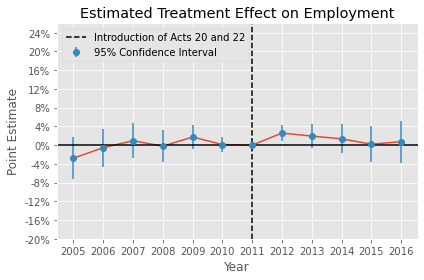

In [26]:
# REGRESSION MODEL

# Define variable of interest: per capita annual avg employment level
y = np.log(panel_reg['pc_annual_avg_emplvl'])

# Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
# Note that 2011–year prior to the intervention–is not included in the exogenous variables
# This makes all coefficient estimates interpretable as relative to 2011
exog = sm.add_constant(panel_reg[['2005_pr', '2006_pr',
       '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
       '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

# Running weighted OLS model
res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                weights=panel_reg['weight'],             # Using weights calculated through IPTW
                entity_effects=True, time_effects=True)) # Setting fixed effects

# Fitting model, using clustered standard errors for each county-industry
mod_emp = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)

# Present model results
print(mod_emp)


# PARAMETER MANAGEMENT

# Extract point estimates and save in chronological order
ests = mod_emp.params          # Extract model output
param_list = np.zeros(len(ests))  # Empty list to save correctly ordered estimates
param_list[0:6] = ests[1:7]       # Drop constant and save 2005 - 2010 values
param_list[6] = 0                 # Code 2011 as 0; all coefficients will be interpretable to 2011 levels
param_list[7:] = ests[7:]         # Save 2012 - 2016 values

# Extract 95% confidence intervals for point estimates
ci = (mod_emp.conf_int().reindex(['2005_pr', '2006_pr',                   # Save confidence interval output
                                    '2007_pr', '2008_pr', '2009_pr',      # And re-order to chronological order
                                    '2010_pr', 'const','2012_pr',   
                                    '2013_pr', '2014_pr', '2015_pr',    
                                    '2016_pr']))  
  
lower_error = param_list - np.array(ci['lower'].reset_index(drop=True))   # Calc dist. from param to lower bound
upper_error = np.array(ci['upper'].reset_index(drop=True)) - param_list   # Calc dist. from upper bound to param
errors = [lower_error,upper_error]                                        # Create list with distances for matplotlib


# VISUALIZATION


fig,ax = plt.subplots()                                          # Create figure and ax
ax.plot(param_list)                                              # Plot values
ax.errorbar(x=np.arange(len(param_list)),                        # Provide x tick locations
            y=param_list,                                        # Provide y values
            yerr=errors, fmt='o',                                # Provide list with lower and upper bounds
            label='95% Confidence Interval')                     # Provide label 
ax.set_xticks(np.arange(len(ests)))                              # Provide x tick locations, 0 to 11 values
ax.set_xticklabels(np.arange(2005,2017).astype(str))             # List of years as strings to be plotted in xtick locations
ax.set_title('Estimated Treatment Effect on Employment')         # Set titles and labels            
ax.set_xlabel('Year')
ax.set_ylabel('Point Estimate')
ax.axvline(6,color='k',                                          # Location 6 = Year 2011
           label='Introduction of Acts 20 and 22', ls = '--')
ax.axhline(0,color='k')
ax.set_yticks(np.arange(-.20,.28,0.04))                          # Setting y tick spacing
ax.set_ylim([-.20, .26])                                         # Visualization limits
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1,      # Formatting percentage, xmax=1 means 1 = 100%
                                                    decimals=0)) # Decimals = 0 -> No decimals in format
ax.legend()                   
fig.set_tight_layout(True)                                       # Visualization cleanliness

##### Establishments

                           PanelOLS Estimation Summary                            
Dep. Variable:     pc_annual_avg_estabs   R-squared:                        0.0041
Estimator:                     PanelOLS   R-squared (Between):             -0.0002
No. Observations:                407424   R-squared (Within):               0.0056
Date:                  Tue, Dec 14 2021   R-squared (Overall):          -9.555e-05
Time:                          17:55:48   Log-likelihood                   1.8e+05
Cov. Estimator:               Clustered                                           
                                          F-statistic:                   1.257e+05
Entities:                         33952   P-value                           0.0000
Avg Obs:                         12.000   Distribution:               F(11,373222)
Min Obs:                         12.000                                           
Max Obs:                         12.000   F-statistic (robust):             67.111
    

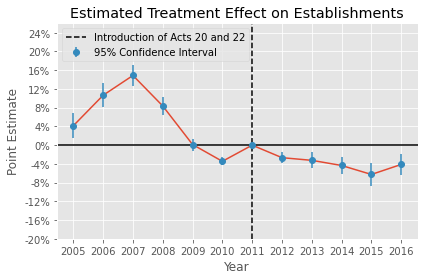

In [27]:
# REGRESSION MODEL

# Define variable of interest: per capita annual average establishments
y = np.log(panel_reg['pc_annual_avg_estabs'])

# Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
# Note that 2011–year prior to the intervention–is not included in the exogenous variables
# This makes all coefficient estimates interpretable as relative to 2011
exog = sm.add_constant(panel_reg[['2005_pr', '2006_pr',
       '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
       '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

# Running weighted OLS model
res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                weights=panel_reg['weight'],             # Using weights calculated through IPTW
                entity_effects=True, time_effects=True)) # Setting fixed effects

# Fitting model, using clustered standard errors for each county-industry
mod_estabs = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)

# Present model results
print(mod_estabs)


# PARAMETER MANAGEMENT

# Extract point estimates and save in chronological order
ests = mod_estabs.params           # Extract model output
param_list = np.zeros(len(ests))  # Empty list to save correctly ordered estimates
param_list[0:6] = ests[1:7]       # Drop constant and save 2005 - 2010 values
param_list[6] = 0                 # Code 2011 as 0; all coefficients will be interpretable to 2011 levels
param_list[7:] = ests[7:]         # Save 2012 - 2016 values

# Extract 95% confidence intervals for point estimates
ci = (mod_estabs.conf_int().reindex(['2005_pr', '2006_pr',                 # Save confidence interval output
                                    '2007_pr', '2008_pr', '2009_pr',      # And re-order to chronological order
                                    '2010_pr', 'const','2012_pr',   
                                    '2013_pr', '2014_pr', '2015_pr',    
                                    '2016_pr']))  
  
lower_error = param_list - np.array(ci['lower'].reset_index(drop=True))   # Calc dist. from param to lower bound
upper_error = np.array(ci['upper'].reset_index(drop=True)) - param_list   # Calc dist. from upper bound to param
errors = [lower_error,upper_error]                                        # Create list with distances for matplotlib


# VISUALIZATION


fig,ax = plt.subplots()                                          # Create figure and ax
ax.plot(param_list)                                              # Plot values
ax.errorbar(x=np.arange(len(param_list)),                        # Provide x tick locations
            y=param_list,                                        # Provide y values
            yerr=errors, fmt='o',                                # Provide list with lower and upper bounds
            label='95% Confidence Interval')                     # Provide label 
ax.set_xticks(np.arange(len(ests)))                              # Provide x tick locations, 0 to 11 values
ax.set_xticklabels(np.arange(2005,2017).astype(str))             # List of years as strings to be plotted in xtick locations
ax.set_title('Estimated Treatment Effect on Establishments')     # Set titles and labels            
ax.set_xlabel('Year')
ax.set_ylabel('Point Estimate')
ax.axvline(6,color='k',                                          # Location 6 = Year 2011
           label='Introduction of Acts 20 and 22', ls = '--')
ax.axhline(0,color='k')
ax.set_yticks(np.arange(-.20,.28,0.04))                          # Setting y tick spacing
ax.set_ylim([-.20, .26])                                         # Visualization limits
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1,      # Formatting percentage, xmax=1 means 1 = 100%
                                                    decimals=0)) # Decimals = 0 -> No decimals in format
ax.legend()                   
fig.set_tight_layout(True)                                       # Visualization cleanliness

##### Wages

                            PanelOLS Estimation Summary                            
Dep. Variable:     pc_total_annual_wages   R-squared:                        0.0004
Estimator:                      PanelOLS   R-squared (Between):              0.0004
No. Observations:                 407424   R-squared (Within):              -0.0005
Date:                   Tue, Dec 14 2021   R-squared (Overall):              0.0004
Time:                           17:55:54   Log-likelihood                   -6182.6
Cov. Estimator:                Clustered                                           
                                           F-statistic:                   3.362e+04
Entities:                          33952   P-value                           0.0000
Avg Obs:                          12.000   Distribution:               F(11,373222)
Min Obs:                          12.000                                           
Max Obs:                          12.000   F-statistic (robust):            

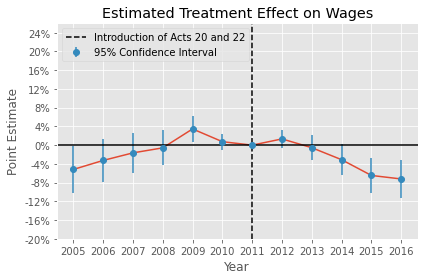

In [28]:
# REGRESSION MODEL

# Define variable of interest: per capita total annual wages
y = np.log(panel_reg['pc_total_annual_wages'])

# Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
# Note that 2011–year prior to the intervention–is not included in the exogenous variables
# This makes all coefficient estimates interpretable as relative to 2011
exog = sm.add_constant(panel_reg[['2005_pr', '2006_pr',
       '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
       '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

# Running weighted OLS model
res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                weights=panel_reg['weight'],             # Using weights calculated through IPTW
                entity_effects=True, time_effects=True)) # Setting fixed effects

# Fitting model, using clustered standard errors for each county-industry
mod_wages = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)

# Present model results
print(mod_wages)


# PARAMETER MANAGEMENT

# Extract point estimates and save in chronological order
ests = mod_wages.params           # Extract model output
param_list = np.zeros(len(ests))  # Empty list to save correctly ordered estimates
param_list[0:6] = ests[1:7]       # Drop constant and save 2005 - 2010 values
param_list[6] = 0                 # Code 2011 as 0; all coefficients will be interpretable to 2011 levels
param_list[7:] = ests[7:]         # Save 2012 - 2016 values

# Extract 95% confidence intervals for point estimates
ci = (mod_wages.conf_int().reindex(['2005_pr', '2006_pr',                 # Save confidence interval output
                                    '2007_pr', '2008_pr', '2009_pr',      # And re-order to chronological order
                                    '2010_pr', 'const','2012_pr',   
                                    '2013_pr', '2014_pr', '2015_pr',    
                                    '2016_pr']))  
  
lower_error = param_list - np.array(ci['lower'].reset_index(drop=True))   # Calc dist. from param to lower bound
upper_error = np.array(ci['upper'].reset_index(drop=True)) - param_list   # Calc dist. from upper bound to param
errors = [lower_error,upper_error]                                        # Create list with distances for matplotlib


# VISUALIZATION


fig,ax = plt.subplots()                                          # Create figure and ax
ax.plot(param_list)                                              # Plot values
ax.errorbar(x=np.arange(len(param_list)),                        # Provide x tick locations
            y=param_list,                                        # Provide y values
            yerr=errors, fmt='o',                                # Provide list with lower and upper bounds
            label='95% Confidence Interval')                     # Provide label 
ax.set_xticks(np.arange(len(ests)))                              # Provide x tick locations, 0 to 11 values
ax.set_xticklabels(np.arange(2005,2017).astype(str))             # List of years as strings to be plotted in xtick locations
ax.set_title('Estimated Treatment Effect on Wages')              # Setting titles and labels
ax.set_xlabel('Year')
ax.set_ylabel('Point Estimate')
ax.axvline(6,color='k',                                          # Location 6 = Year 2011
           label='Introduction of Acts 20 and 22', ls = '--')
ax.axhline(0,color='k')
ax.set_yticks(np.arange(-.20,.28,0.04))                          # Setting y tick spacing
ax.set_ylim([-.20, .26])                                         # Visualization limits
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1,      # Formatting percentage, xmax=1 means 1 = 100%
                                                    decimals=0)) # Decimals = 0 -> No decimals in format
ax.legend()                   
fig.set_tight_layout(True)                                       # Visualization cleanliness

#### Regression Table Outputs

In [29]:
# Use compare to print regression outputs with stars signifying statistical singificance
print(compare({' ' : mod_emp}, stars=True))
print(compare({' ' : mod_estabs}, stars=True))
print(compare({' ' : mod_wages}, stars=True))

                Model Comparison                
                                                
------------------------------------------------
Dep. Variable               pc_annual_avg_emplvl
Estimator                               PanelOLS
No. Observations                          407424
Cov. Est.                              Clustered
R-squared                              9.535e-05
R-Squared (Within)                       -0.0002
R-Squared (Between)                   -5.666e-05
R-Squared (Overall)                   -5.954e-05
F-statistic                            3.164e+04
P-value (F-stat)                          0.0000
=====================     ======================
const                                 -4.6935***
                                    (-2.077e+04)
2005_pr                                  -0.0278
                                       (-1.2193)
2006_pr                                  -0.0055
                                       (-0.2669)
2007_pr             

### Robustness Checks

#### Varying Growth Rates

In [30]:
# DEFINING FUNCTION TO BE USED

def growth_variation(growth_predictors):
    
    # RESETTING THE DATA
    county_summ_df = copy.deepcopy(county_summ_df_b)
    county_industry_df = copy.deepcopy(county_industry_df_b)
    data_2011 = copy.deepcopy(data_2011_b)
    
    # VARYING PREDICTORS FOR THE MATCHING PROCESS

    # Define base predictors
    preds = ['pc_total_annual_wages', 'pc_annual_avg_emplvl', 'pc_annual_avg_estabs', 'food_share', 'manuf_share', 'services_share']
    
    # Append period-specific predictors, passed into the function 
    preds.extend(growth_predictors)
    
    # MATCHING PROCESS
    
    # Subset predictor data
    x = data_2011[preds]

    # Define outcome of interest - dummy for being in Puerto Rico
    y = data_2011['pr_dummy']

    # Write formula for predictors
    formula = 'pr_dummy ~ '             # Define dependent variable and begin formula
    for p in preds[:-1]:                # Loop through all the predictors, except the last one
        formula = formula + p + ' + '   # Add each predictor except last one to formula
    formula = formula + preds[-1]       # Add remaining predictor (i.e. last one) to the formula

    # Build model         
    m1 = smf.logit(formula=formula, data=data_2011).fit()

    # Matching Model Summary
    match_summ = m1

    # Estimate probability of being in Puerto Rico
    ps = m1.predict(x)

    # Create weights equal to the inverse of the probability of treatment received
    
    data_2011['weight'] = np.zeros(len(ps)) # List to store values

    for i in np.arange(len(ps)):            # Calculating and storing
        if data_2011['pr_dummy'][i] == 1:
            weight = 1/ps[i]
        else:
            weight = 1/(1-ps[i]) 
        data_2011['weight'][i] = weight

    # Winsorize weights array at the 1% and 99% levels
    data_2011['weight'] = mstats.winsorize(data_2011['weight'],0.01)

    # Create weights df
    weights_df = data_2011[['area_fips','weight']]

    # Add 2011 fixed weights to all observations for each area-industry
    county_industry_df = pd.merge(county_industry_df,weights_df,how='left',on=['area_fips'])

    # Create regression panel
    panel_reg = county_industry_df.set_index(['area_industry', 'time_industry']) #Set entity and time indeces
    
    # __________________________________________________
    # REGRESSION NO. 1:  PER CAPITA ANNUAL AVG EMPLOYMENT
    
    # Define variable of interest: per capita total annual wages
    y = np.log(panel_reg['pc_annual_avg_emplvl'])

    # Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
    # Note that 2011–year prior to the intervention–is not included in the exogenous variables
    # This makes all coefficient estimates interpretable as relative to 2011
    exog = sm.add_constant(panel_reg[['2005_pr', '2006_pr',
           '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
           '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

    # Running weighted OLS model
    res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                    weights=panel_reg['weight'],             # Using weights calculated through IPTW
                    entity_effects=True, time_effects=True)) # Setting fixed effects

    # Fitting model, using clustered standard errors for each county-industry
    mod = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)
    
    # Save the model summary
    emp_summ = mod
    
    #Create the ordered parameter estimates
    ests = mod.params
    param_list = np.zeros(len(ests))
    param_list[0:6] = ests[1:7]
    param_list[6] = 0
    param_list[7:] = ests[7:]
    emp_params = param_list
    
    # __________________________________________________
    # REGRESSION NO. 2:  PER CAPITA ANNUAL ESTABS
    
    # Define variable of interest: per capita total annual wages
    y = np.log(panel_reg['pc_annual_avg_estabs'])

    # Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
    # Note that 2011–year prior to the intervention–is not included in the exogenous variables
    # This makes all coefficient estimates interpretable as relative to 2011
    exog = sm.add_constant(panel_reg[['2005_pr', '2006_pr',
           '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
           '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

    # Running weighted OLS model
    res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                    weights=panel_reg['weight'],             # Using weights calculated through IPTW
                    entity_effects=True, time_effects=True)) # Setting fixed effects

    # Fitting model, using clustered standard errors for each county-industry
    mod = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)
    
    # Save the model summary
    estabs_summ = mod
    
    #Create the ordered parameter estimates
    ests = mod.params
    param_list = np.zeros(len(ests))
    param_list[0:6] = ests[1:7]
    param_list[6] = 0
    param_list[7:] = ests[7:]
    estabs_params = param_list
    
    # __________________________________________________
    # REGRESSION NO. 3:  PER CAPITA ANNUAL WAGES
    
    # Define variable of interest: per capita total annual wages
    y = np.log(panel_reg['pc_total_annual_wages'])

    # Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
    # Note that 2011–year prior to the intervention–is not included in the exogenous variables
    # This makes all coefficient estimates interpretable as relative to 2011
    exog = sm.add_constant(panel_reg[['2005_pr', '2006_pr',
           '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
           '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

    # Running weighted OLS model
    res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                    weights=panel_reg['weight'],             # Using weights calculated through IPTW
                    entity_effects=True, time_effects=True)) # Setting fixed effects

    # Fitting model, using clustered standard errors for each county-industry
    mod = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)
    
    # Save the model summary
    wages_summ = mod
    
    #Create the ordered parameter estimates
    ests = mod.params
    param_list = np.zeros(len(ests))
    param_list[0:6] = ests[1:7]
    param_list[6] = 0
    param_list[7:] = ests[7:]
    wages_params = param_list
    
    return match_summ, emp_summ, emp_params, estabs_summ, estabs_params, wages_summ, wages_params

In [31]:
# CREATE SET OF PERIOD VARIABLES TO BE USED

g_pds = ['g_2005_2011_', 'g_2007_2011_', 'g_2009_2011_']    # Periods over which to calculate growth rates 
var_list = ['pc_annual_avg_estabs', 'pc_annual_avg_emplvl', # Variables of interest
            'pc_total_annual_wages']

g_pd_l = []                 # List to save period-variable combinations

for p in g_pds:                      # Loop over all the periods
    pd_vars = []                     # List to save variables for this period
    for var in var_list:             # Loop over all variables
        joint = p + var              # Combine period and variable
        pd_vars.append(joint)        # Save period-variable combination into period list
    g_pd_l.append(pd_vars)  # Save period list into yearly predictor set list
    
# PREPARE VISUALIZATIONS MATCHES ON DIFFERENT GROWTH PERIODS

# Prepare lists to save outputs for models matched on different growth rates
match_summ_l_g = []     # Matching model summary
wages_summ_l_g = []     # Wages model summary
wages_params_l_g = []   # Wages model parameters
estabs_summ_l_g = []    # Establishment model summary
estabs_params_l_g = []  # Establishment model parameters
emp_summ_l_g = []       # Employment model summary 
emp_params_l_g = []     # Employment model parameters

# Loop over yearly predictor sets
for yearly_preds in g_pd_l:
    (match_summ, emp_summ, emp_params, estabs_summ,   # Run function and save relevant outputs
     estabs_params, wages_summ, wages_params) =       growth_variation(yearly_preds) 
    
    # Save relevant outputs to lists defined above
    match_summ_l_g.append(match_summ)
    wages_summ_l_g.append(wages_summ)
    wages_params_l_g.append(wages_params)
    estabs_summ_l_g.append(estabs_summ)
    estabs_params_l_g.append(estabs_params)
    emp_summ_l_g.append(emp_summ)
    emp_params_l_g.append(emp_params)

Optimization terminated successfully.
         Current function value: 0.037295
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.031189
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.035936
         Iterations 14


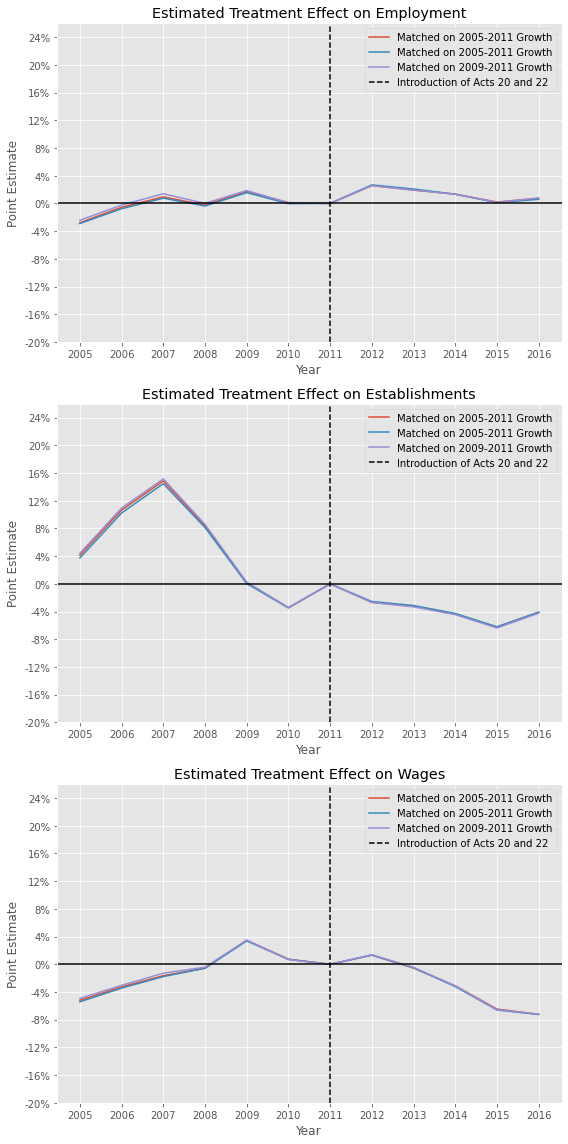

In [32]:
# VISUALIZATIONS FOR ROBUSTNESS CHECKS 

# Define title labels
title_l_g =  ['Estimated Treatment Effect on Employment', 
              'Estimated Treatment Effect on Establishments',
              'Estimated Treatment Effect on Wages']

# Define period labels
pd_labels = ['Matched on 2005-2011 Growth',
            'Matched on 2005-2011 Growth',
            'Matched on 2009-2011 Growth']

# Create list of parameters over which to iterate
params_l_o_l_g = [emp_params_l_g, estabs_params_l_g, wages_params_l_g]

# Create matplotlib figure and subplots
fig, ax = plt.subplots(3,1, figsize=(8,16))

# Loop over all parameters of interest 
for i, lists in enumerate(params_l_o_l_g):
    
    # Set title according to parameter of interest
    ax[i].set_title(title_l_g[i])
    
    # Access data for our parameter of interest being plotted
    data = params_l_o_l_g[i]
    
    # Access data for each period and plot
    for p, data in enumerate(data):
        ax[i].plot(data, label = pd_labels[p])
        
    # Formatting x ticks and x label
    ax[i].set_xticks(np.arange(len(ests)))
    ax[i].set_xticklabels(np.arange(2005,2017).astype(str))
    ax[i].set_xlabel('Year')
    
    # Formatting y ticks and y label
    ax[i].set_ylabel('Point Estimate')
    ax[i].set_yticks(np.arange(-.20,.28,0.04))
    ax[i].set_ylim([-.20, .26])
    
    # Adding lines showing: 
    ax[i].axvline(6,color='k', label='Introduction of Acts 20 and 22', ls = '--') # Intervention, 6 = yr 2011
    ax[i].axhline(0,color='k')                                                    # 0 axis
    
    # Formatting y axis: xmax=1 -> 1 = 100%
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    
    # Show legend
    ax[i].legend()
    
# Clean formatting 
fig.set_tight_layout(True)

#### Varying Predictor Sets

In [33]:
# DEFINING FUNCTION
def pred_variation(pred_set):
    """Function takes pred_set, a list of predictors to be used, as an argument."""
    
    # RESETTING THE DATA
    county_summ_df = copy.deepcopy(county_summ_df_b)
    county_industry_df = copy.deepcopy(county_industry_df_b)
    data_2011 = copy.deepcopy(data_2011_b)
    
    # VARYING PREDICTORS FOR THE MATCHING PROCESS
    
    # MATCHING PROCESS
    
    # Subset predictor data
    x = data_2011[preds]

    # Define outcome of interest - dummy for being in Puerto Rico
    y = data_2011['pr_dummy']

    # Write formula for predictors
    formula = 'pr_dummy ~ '                # Define dependent variable and begin formula
    for p in pred_set[:-1]:                # Loop through all the predictors, except the last one
        formula = formula + p + ' + '      # Add each predictor except last one to formula
    formula = formula + pred_set[-1]       # Add remaining predictor (i.e. last one) to the formula

    # Build model         
    m1 = smf.logit(formula=formula, data=data_2011).fit()

    # Matching Model Summary
    match_summ = m1

    # Estimate probability of being in Puerto Rico
    ps = m1.predict(x)

    # Create weights equal to the inverse of the probability of treatment received
    
    data_2011['weight'] = np.zeros(len(ps)) # List to store values

    for i in np.arange(len(ps)):            # Calculating and storing
        if data_2011['pr_dummy'][i] == 1:
            weight = 1/ps[i]
        else:
            weight = 1/(1-ps[i]) 
        data_2011['weight'][i] = weight

    # Winsorize weights array at the 1% and 99% levels
    data_2011['weight'] = mstats.winsorize(data_2011['weight'],0.01)

    # Create weights df
    weights_df = data_2011[['area_fips','weight']]

    # Add 2011 fixed weights to all observations for each area-industry
    county_industry_df = pd.merge(county_industry_df,weights_df,how='left',on=['area_fips'])

    # Create regression panel
    panel_reg = county_industry_df.set_index(['area_industry', 'time_industry']) #Set entity and time indeces
    
    # __________________________________________________
    # REGRESSION NO. 1:  PER CAPITA ANNUAL AVG EMPLOYMENT
    
    # Define variable of interest: per capita total annual wages
    y = np.log(panel_reg['pc_annual_avg_emplvl'])

    # Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
    # Note that 2011–year prior to the intervention–is not included in the exogenous variables
    # This makes all coefficient estimates interpretable as relative to 2011
    exog = sm.add_constant(panel_reg[['2005_pr', '2006_pr',
           '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
           '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

    # Running weighted OLS model
    res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                    weights=panel_reg['weight'],             # Using weights calculated through IPTW
                    entity_effects=True, time_effects=True)) # Setting fixed effects

    # Fitting model, using clustered standard errors for each county-industry
    mod = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)
    
    # Save the model summary
    emp_summ = mod
    
    #Create the ordered parameter estimates
    ests = mod.params
    param_list = np.zeros(len(ests))
    param_list[0:6] = ests[1:7]
    param_list[6] = 0
    param_list[7:] = ests[7:]
    emp_params = param_list
    
    # __________________________________________________
    # REGRESSION NO. 2:  PER CAPITA ANNUAL ESTABS
    
    # Define variable of interest: per capita total annual wages
    y = np.log(panel_reg['pc_annual_avg_estabs'])

    # Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
    # Note that 2011–year prior to the intervention–is not included in the exogenous variables
    # This makes all coefficient estimates interpretable as relative to 2011
    exog = sm.add_constant(panel_reg[['2005_pr', '2006_pr',
           '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
           '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

    # Running weighted OLS model
    res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                    weights=panel_reg['weight'],             # Using weights calculated through IPTW
                    entity_effects=True, time_effects=True)) # Setting fixed effects

    # Fitting model, using clustered standard errors for each county-industry
    mod = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)
    
    # Save the model summary
    estabs_summ = mod
    
    #Create the ordered parameter estimates
    ests = mod.params
    param_list = np.zeros(len(ests))
    param_list[0:6] = ests[1:7]
    param_list[6] = 0
    param_list[7:] = ests[7:]
    estabs_params = param_list
    
    # __________________________________________________
    # REGRESSION NO. 3:  PER CAPITA ANNUAL WAGES
    
    # Define variable of interest: per capita total annual wages
    y = np.log(panel_reg['pc_total_annual_wages'])

    # Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
    # Note that 2011–year prior to the intervention–is not included in the exogenous variables
    # This makes all coefficient estimates interpretable as relative to 2011
    exog = sm.add_constant(panel_reg[['2005_pr', '2006_pr',
           '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
           '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

    # Running weighted OLS model
    res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                    weights=panel_reg['weight'],             # Using weights calculated through IPTW
                    entity_effects=True, time_effects=True)) # Setting fixed effects

    # Fitting model, using clustered standard errors for each county-industry
    mod = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)
    
    # Save the model summary
    wages_summ = mod
    
    #Create the ordered parameter estimates
    ests = mod.params
    param_list = np.zeros(len(ests))
    param_list[0:6] = ests[1:7]
    param_list[6] = 0
    param_list[7:] = ests[7:]
    wages_params = param_list
    
    return match_summ, emp_summ, emp_params, estabs_summ, estabs_params, wages_summ, wages_params

In [34]:
# Define list with all potential predictors
all_preds = ['pc_total_annual_wages', 'pc_annual_avg_emplvl', 'pc_annual_avg_estabs', 
             'food_share', 'manuf_share', 'services_share', 
             'g_2005_2011_pc_annual_avg_estabs','g_2005_2011_pc_annual_avg_emplvl',
             'g_2005_2011_pc_total_annual_wages']

# Define predictor sets 
pred_set_1 = all_preds[0:6]                  # Current values and industry mix
pred_set_2 = all_preds[3:9]                  # Industry mix and gorwth rates
pred_set_3 = all_preds[0:3] + all_preds[6:9] # Current values and growth rates

# Pred_set list
pred_set_l_o_l = [pred_set_1, pred_set_2, pred_set_3, all_preds]

#Create empty lists to store results
match_summ_l_p = []
wages_summ_l_p = []
wages_params_l_p = []
estabs_summ_l_p = []
estabs_params_l_p = []
emp_summ_l_p = []
emp_params_l_p = []

# Loop over predictor sets
for preds in pred_set_l_o_l:
    (match_summ, emp_summ, emp_params, estabs_summ,   # Run function and save relevant outputs
     estabs_params, wages_summ, wages_params) =       pred_variation(preds) 
    
    # Save relevant outputs to lists defined above
    match_summ_l_p.append(match_summ)
    wages_summ_l_p.append(wages_summ)
    wages_params_l_p.append(wages_params)
    estabs_summ_l_p.append(estabs_summ)
    estabs_params_l_p.append(estabs_params)
    emp_summ_l_p.append(emp_summ)
    emp_params_l_p.append(emp_params)

Optimization terminated successfully.
         Current function value: 0.037375
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.104057
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.037918
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.037295
         Iterations 14


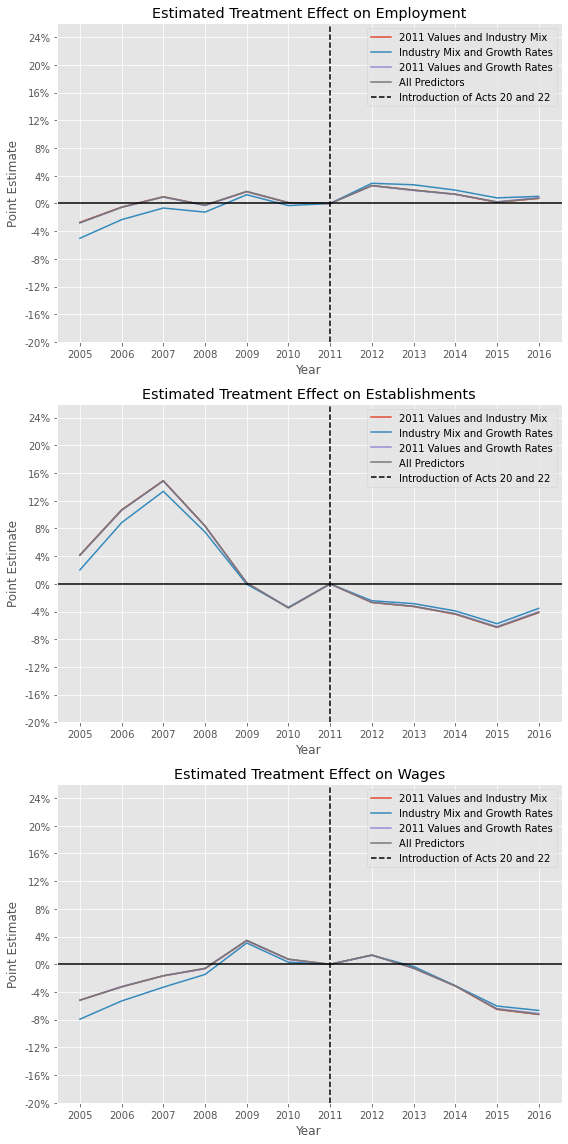

In [35]:
# VISUALIZATIONS FOR ROBUSTNESS CHECKS 

# Define title labels
title_l_g =  ['Estimated Treatment Effect on Employment', 
              'Estimated Treatment Effect on Establishments',
              'Estimated Treatment Effect on Wages']

# Define period labels
pd_labels = ['2011 Values and Industry Mix',
            'Industry Mix and Growth Rates',
            '2011 Values and Growth Rates',
            'All Predictors']

# Create list of parameters over which to iterate
params_l_o_l_p = [emp_params_l_p, estabs_params_l_p, wages_params_l_p]

# Create matplotlib figure and subplots
fig, ax = plt.subplots(3,1, figsize=(8,16))

# Loop over all parameters of interest 
for i, lists in enumerate(params_l_o_l_p):
    
    # Set title according to parameter of interest
    ax[i].set_title(title_l_g[i])
    
    # Access data for our parameter of interest being plotted
    data = params_l_o_l_p[i]
    
    # Access data for each predset and plot
    for p, data in enumerate(data):
        ax[i].plot(data, label = pd_labels[p])
        
    # Formatting x ticks and x label
    ax[i].set_xticks(np.arange(len(ests)))
    ax[i].set_xticklabels(np.arange(2005,2017).astype(str))
    ax[i].set_xlabel('Year')
    
    # Formatting y ticks and y label
    ax[i].set_ylabel('Point Estimate')
    ax[i].set_yticks(np.arange(-.20,.28,0.04))
    ax[i].set_ylim([-.20, .26])
    
    # Adding lines showing: 
    ax[i].axvline(6,color='k', label='Introduction of Acts 20 and 22', ls = '--') # Intervention, 6 = yr 2011
    ax[i].axhline(0,color='k')                                                    # 0 axis
    
    # Formatting y axis: xmax=1 -> 1 = 100%
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    
    # Show legend
    ax[i].legend()
    
# Clean formatting 
fig.set_tight_layout(True)

#### Varying Winsorization

In [36]:
def winsorization_variation(wins_level):
    """Prior to running this function, run IPTW on the baseline model and save the results in a dataframe
    called data_2011. This will contain original weights. The function will reset a local dataframe and 
    winsorize the original weights. The data is reset every attempt to ensure you do not winsorize
    already-winsorized weights.
    
    wins_level = float between 0 and 1.
    
    Weights will be winsorized at the wins_level and (1 - wins_level) levels. """
    
    # Create unique data set for this winsorization
    data_2011_w = copy.deepcopy(data_2011)                   # Copy of data_2011 with original weights
    county_industry_df = copy.deepcopy(county_industry_df_b)
    
    # Winsorize weights array at the x% level
    if wins_level == 0:
        data_2011_w['weight'] = data_2011['weight']
    else:      
        data_2011_w['weight'] = mstats.winsorize(data_2011['weight'],wins_level)

    # Create weights df
    weights_df = data_2011_w[['area_fips','weight']]

    # Add 2011 fixed weights to all observations for each area-industry
    county_industry_df = pd.merge(county_industry_df,weights_df,how='left',on=['area_fips'])

    #Create regression panel
    panel_reg = county_industry_df.set_index(['area_industry', 'time_industry']) #Set entity and time indeces
    
    # __________________________________________________
    # REGRESSION NO. 1:  PER CAPITA ANNUAL AVG EMPLOYMENT
    
    # Define variable of interest: per capita total annual wages
    y = np.log(panel_reg['pc_annual_avg_emplvl'])

    # Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
    # Note that 2011–year prior to the intervention–is not included in the exogenous variables
    # This makes all coefficient estimates interpretable as relative to 2011
    exog = sm.add_constant(panel_reg[['2005_pr', '2006_pr',
           '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
           '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

    # Running weighted OLS model
    res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                    weights=panel_reg['weight'],             # Using weights calculated through IPTW
                    entity_effects=True, time_effects=True)) # Setting fixed effects

    # Fitting model, using clustered standard errors for each county-industry
    mod = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)
    
    # Save the model summary
    emp_summ = mod
    
    #Create the ordered parameter estimates
    ests = mod.params
    param_list = np.zeros(len(ests))
    param_list[0:6] = ests[1:7]
    param_list[6] = 0
    param_list[7:] = ests[7:]
    emp_params = param_list
    
    # __________________________________________________
    # REGRESSION NO. 2:  PER CAPITA ANNUAL ESTABS
    
    # Define variable of interest: per capita total annual wages
    y = np.log(panel_reg['pc_annual_avg_estabs'])

    # Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
    # Note that 2011–year prior to the intervention–is not included in the exogenous variables
    # This makes all coefficient estimates interpretable as relative to 2011
    exog = sm.add_constant(panel_reg[['2005_pr', '2006_pr',
           '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
           '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

    # Running weighted OLS model
    res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                    weights=panel_reg['weight'],             # Using weights calculated through IPTW
                    entity_effects=True, time_effects=True)) # Setting fixed effects

    # Fitting model, using clustered standard errors for each county-industry
    mod = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)
    
    # Save the model summary
    estabs_summ = mod
    
    #Create the ordered parameter estimates
    ests = mod.params
    param_list = np.zeros(len(ests))
    param_list[0:6] = ests[1:7]
    param_list[6] = 0
    param_list[7:] = ests[7:]
    estabs_params = param_list
    
    # __________________________________________________
    # REGRESSION NO. 3:  PER CAPITA ANNUAL WAGES
    
    # Define variable of interest: per capita total annual wages
    y = np.log(panel_reg['pc_total_annual_wages'])

    # Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
    # Note that 2011–year prior to the intervention–is not included in the exogenous variables
    # This makes all coefficient estimates interpretable as relative to 2011
    exog = sm.add_constant(panel_reg[['2005_pr', '2006_pr',
           '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
           '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

    # Running weighted OLS model
    res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                    weights=panel_reg['weight'],             # Using weights calculated through IPTW
                    entity_effects=True, time_effects=True)) # Setting fixed effects

    # Fitting model, using clustered standard errors for each county-industry
    mod = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)
    
    # Save the model summary
    wages_summ = mod
    
    #Create the ordered parameter estimates
    ests = mod.params
    param_list = np.zeros(len(ests))
    param_list[0:6] = ests[1:7]
    param_list[6] = 0
    param_list[7:] = ests[7:]
    wages_params = param_list
    
    return match_summ, emp_summ, emp_params, estabs_summ, estabs_params, wages_summ, wages_params

In [37]:
# PREPARE data_2011 DATA FRAME CONSISTING OF BASELINE MODEL WEIGHTS, WITH NO WINSORIZATION

# Resetting data
county_summ_df = copy.deepcopy(county_summ_df_b)
county_industry_df = copy.deepcopy(county_industry_df_b)
data_2011 = copy.deepcopy(data_2011_b)

#Define predictors
preds = ['pc_total_annual_wages', 'pc_annual_avg_emplvl', 'pc_annual_avg_estabs', 
         'food_share', 'manuf_share', 'services_share', 
         'g_2005_2011_pc_annual_avg_estabs','g_2005_2011_pc_annual_avg_emplvl',
         'g_2005_2011_pc_total_annual_wages']

# MATCHING PROCESS

# Subset predictor data
x = data_2011[preds]

# Define outcomes
y = data_2011['pr_dummy']

# Write formula for predictors
formula = 'pr_dummy ~ '
for p in preds[:-1]:
    formula = formula + p + ' + '
formula = formula + preds[-1]   

# Build model         
m1 = smf.logit(formula=formula, data=data_2011).fit()

# Matching model summary
match_summ = m1

# Predict probability of county being located in Puerto Rico
ps = m1.predict(x)

# Create weights equal to the reciprocal of the probability of receiving the treatment actually received
data_2011['weight'] = np.zeros(len(ps))   # Empty list to save values

for i in np.arange(len(ps)):              # Calculate and save probabilities
    if data_2011['pr_dummy'][i] == 1:
        weight = 1/ps[i]
    else:
        weight = 1/(1-ps[i]) 
    data_2011['weight'][i] = weight

Optimization terminated successfully.
         Current function value: 0.037295
         Iterations 14


In [38]:
# Define Winsorization Levels
wins_level_l = [0,0.01, 0.025]

#Create empty lists to save output
match_summ_l_w = []
wages_summ_l_w = []
wages_params_l_w = []
estabs_summ_l_w = []
estabs_params_l_w = []
emp_summ_l_w = []
emp_params_l_w = []

# Loop over winsorization levels list
for wins_level in wins_level_l:
    (match_summ, emp_summ, emp_params, estabs_summ,   # Run function and save relevant outputs
     estabs_params, wages_summ, wages_params) =       winsorization_variation(wins_level) 
    
    # Save relevant outputs to lists defined above
    match_summ_l_w.append(match_summ)
    wages_summ_l_w.append(wages_summ)
    wages_params_l_w.append(wages_params)
    estabs_summ_l_w.append(estabs_summ)
    estabs_params_l_w.append(estabs_params)
    emp_summ_l_w.append(emp_summ)
    emp_params_l_w.append(emp_params)

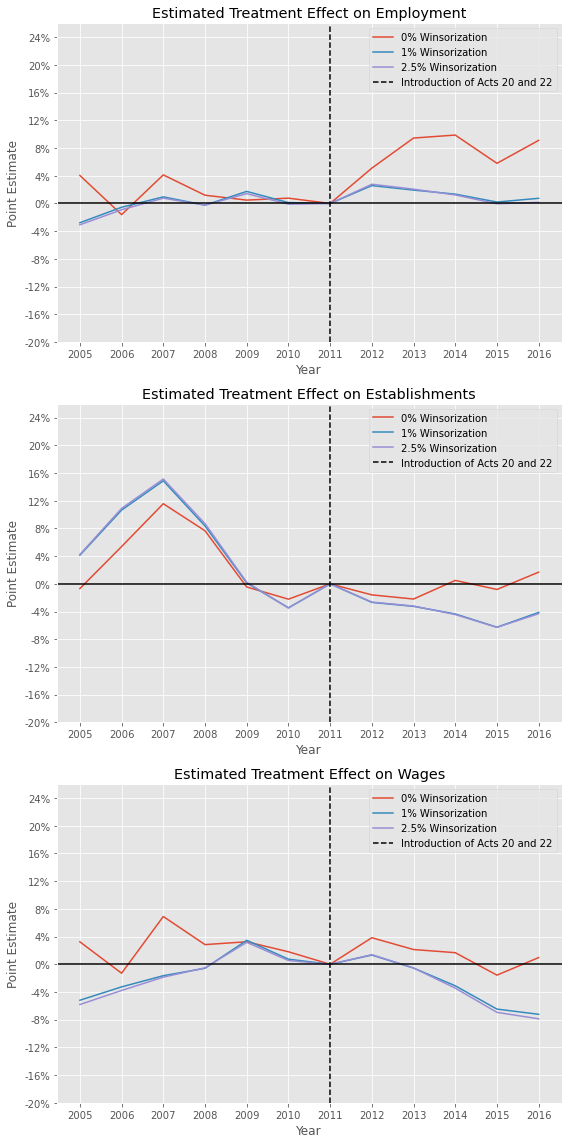

In [39]:
# VISUALIZATIONS FOR ROBUSTNESS CHECKS 

# Define title labels
title_l_g =  ['Estimated Treatment Effect on Employment', 
              'Estimated Treatment Effect on Establishments',
              'Estimated Treatment Effect on Wages']

# Define period labels
w_labels = ['0% Winsorization',
           '1% Winsorization',
           '2.5% Winsorization']

# Create list of parameters over which to iterate
params_l_o_l_w = [emp_params_l_w, estabs_params_l_w, wages_params_l_w]

# Create matplotlib figure and subplots
fig, ax = plt.subplots(3,1, figsize=(8,16))

# Loop over all parameters of interest 
for i, l in enumerate(params_l_o_l_w):
    
    # Set title according to parameter of interest
    ax[i].set_title(title_l_g[i])
    
    # Access data for our parameter of interest being plotted
    data = l
    
    # Access data for each wins_level and plot
    for p, datum in enumerate(data):
        ax[i].plot(datum, label = w_labels[p])
        
    # Formatting x ticks and x label
    ax[i].set_xticks(np.arange(len(ests)))
    ax[i].set_xticklabels(np.arange(2005,2017).astype(str))
    ax[i].set_xlabel('Year')
    
    # Formatting y ticks and y label
    ax[i].set_ylabel('Point Estimate')
    ax[i].set_yticks(np.arange(-.20,.28,0.04))
    ax[i].set_ylim([-.20, .26])
    
    # Adding lines showing: 
    ax[i].axvline(6,color='k', label='Introduction of Acts 20 and 22', ls = '--') # Intervention, 6 = yr 2011
    ax[i].axhline(0,color='k')                                                    # 0 axis
    
    # Formatting y axis: xmax=1 -> 1 = 100%
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    
    # Show legend
    ax[i].legend()
    
# Clean formatting 
fig.set_tight_layout(True)

## NAICS 54 Model

### Panel Preparation

In [40]:
#Create dfs for this attempt by getting base dataframe and extracting NAICS 54 data from it
county_industry_df = copy.deepcopy(county_industry_df_b)
services_df_b = county_industry_df.query('industry_code == 54')

#Define which variables you are interested in finding growth rates
vars_of_interest = ['pc_annual_avg_estabs', 'pc_annual_avg_emplvl', 'pc_total_annual_wages']

#Define periods for growth rates
g_pds = ['g_2005_2011', 'g_2007_2011', 'g_2009_2011']

# Create list of unique area_industries
ai_l = np.unique(services_df_b['area_industry'])

#Create a dictionary in which to store growth rates
g_dict = {'area_industry' : ai_l}

#Create keys for all variables of interest in this dictionary
for c in np.arange(len(vars_of_interest)):
    for p in np.arange(len(g_pds)):
        colname = g_pds[p] + '_' + vars_of_interest[c] 
        g_dict[colname] = []
        
#Go through all the area industries
for r in np.arange(len(ai_l)): 
    
    # Find data for area-industry
    ai_panel = services_df_b[services_df_b['area_industry']==ai_l[r]] 
    
    obs_2005 = ai_panel.query('year == 2005').reset_index(drop=True)   # Pull 2005 obs
    obs_2007 = ai_panel.query('year == 2007').reset_index(drop=True)   # Pull 2007 obs
    obs_2009 = ai_panel.query('year == 2009').reset_index(drop=True)   # Pull 2009 obs
    obs_2011 = ai_panel.query('year == 2011').reset_index(drop=True)   # Pull 2011 obs
    
    #Go through all columns of interest
    for c in np.arange(len(vars_of_interest)): 
        g_2005_2011 = obs_2011[vars_of_interest[c]][0]/obs_2005[vars_of_interest[c]][0] - 1 #Pd 1 g rate in var
        g_2007_2011 = obs_2011[vars_of_interest[c]][0]/obs_2007[vars_of_interest[c]][0] - 1 #Pd 2 g rate in var
        g_2009_2011 = obs_2011[vars_of_interest[c]][0]/obs_2009[vars_of_interest[c]][0] - 1 #Pd 3 g rate in var
        
        
        #Append values to dictionary
        g_dict['g_2005_2011_' + vars_of_interest[c]].append(g_2005_2011) 
        g_dict['g_2007_2011_' + vars_of_interest[c]].append(g_2007_2011)
        g_dict['g_2009_2011_' + vars_of_interest[c]].append(g_2009_2011)

# Covert dictionary into datagrame
county_g_df = pd.DataFrame(g_dict)
        
# Merge services df with growth rates for each county-industry
services_df_b = pd.merge(services_df_b, county_g_df, how='left', on=['area_industry'])

# Subset 2011 service data
data_2011_serv_b = services_df_b.query('year == 2011').reset_index(drop=True)

### Analysis

#### Matching

In [41]:
# Subset data for this attempt
services_df = copy.deepcopy(services_df_b)

# Pull 2011 data for services acrosss counties
data_2011_serv = services_df.query('year == 2011').reset_index(drop=True)

#Define predictors to match on
preds = ['pc_total_annual_wages', 'pc_annual_avg_emplvl', 'pc_annual_avg_estabs', 
         'g_2005_2011_pc_annual_avg_estabs','g_2005_2011_pc_annual_avg_emplvl',
         'g_2005_2011_pc_total_annual_wages']

#Subset predictor data 
x = data_2011_serv[preds]

#Define outcome of interest - dummy variabel for being in Puerto Rico
y = data_2011_serv['pr_dummy']

# Write formula for predictors
formula = 'pr_dummy ~ '             # Define dependent variable and begin formula
for p in preds[:-1]:                # Loop through all the predictors, except the last one
    formula = formula + p + ' + '   # Add each predictor except last one to formula
formula = formula + preds[-1]       # Add remaining predictor (i.e. last one) to the formula
              
#Build model         
m1 = smf.logit(formula=formula, data=data_2011_serv).fit()

#Print results for model
print(m1.summary())

# Estimate probability of each NAICS 54-county combination being located in Puerto Rico NAICS 54
ps = m1.predict(x)

#Create weights equal to the reciprocal of the probability of receiving the treatment actually received
data_2011_serv['weight'] = np.zeros(len(ps))   # Empty list to save weights

for i in np.arange(len(ps)):                   # Calculate and store weights
    if data_2011_serv['pr_dummy'][i] == 1:
        weight = 1/ps[i]
    else:
        weight = 1/(1-ps[i]) 
    data_2011_serv['weight'][i] = weight
    
#Winsorize weights array at the 1% level
data_2011_serv['weight'] = mstats.winsorize(data_2011_serv['weight'],0.01)

#Create weights df
weights_df = data_2011_serv[['area_fips','weight']]

#Add weights to all NAICS 54-county combinations 
services_df = pd.merge(services_df,weights_df,how='left',on=['area_fips'])

#Create regression panel 
service_panel_reg = services_df.set_index(['area_industry', 'year']) #Set entity and time indeces

Optimization terminated successfully.
         Current function value: 0.055018
         Iterations 19
                           Logit Regression Results                           
Dep. Variable:               pr_dummy   No. Observations:                 1377
Model:                          Logit   Df Residuals:                     1370
Method:                           MLE   Df Model:                            6
Date:                Tue, 14 Dec 2021   Pseudo R-squ.:                  0.2750
Time:                        17:59:19   Log-Likelihood:                -75.760
converged:                       True   LL-Null:                       -104.49
Covariance Type:            nonrobust   LLR p-value:                 1.471e-10
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.4355      0.655     -

#### Regressions

##### Employment

                           PanelOLS Estimation Summary                            
Dep. Variable:     pc_annual_avg_emplvl   R-squared:                        0.0271
Estimator:                     PanelOLS   R-squared (Between):             -0.0094
No. Observations:                 16524   R-squared (Within):               0.0302
Date:                  Tue, Dec 14 2021   R-squared (Overall):             -0.0079
Time:                          17:59:20   Log-likelihood                    5229.1
Cov. Estimator:               Clustered                                           
                                          F-statistic:                   2.269e+04
Entities:                          1377   P-value                           0.0000
Avg Obs:                         12.000   Distribution:                F(11,15125)
Min Obs:                         12.000                                           
Max Obs:                         12.000   F-statistic (robust):             4.2409
    

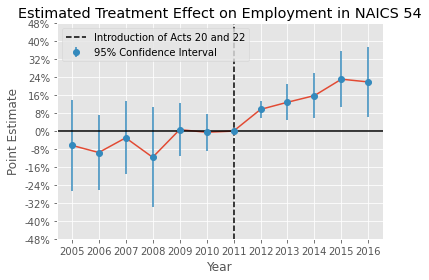

In [42]:
# REGRESSION MODEL

# Define variable of interest: per capita annual avg employment level
y = np.log(service_panel_reg['pc_annual_avg_emplvl'])

# Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
# Note that 2011–year prior to the intervention–is not included in the exogenous variables
# This makes all coefficient estimates interpretable as relative to 2011
exog = sm.add_constant(service_panel_reg[['2005_pr', '2006_pr',
       '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
       '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

# Running weighted OLS model
res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                weights=service_panel_reg['weight'],             # Using weights calculated through IPTW
                entity_effects=True, time_effects=True)) # Setting fixed effects

# Fitting model, using clustered standard errors for each county-industry
serv_mod_emp = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)

# Present model results
print(serv_mod_emp)


# PARAMETER MANAGEMENT

# Extract point estimates and save in chronological order
ests = serv_mod_emp.params          # Extract model output
param_list = np.zeros(len(ests))  # Empty list to save correctly ordered estimates
param_list[0:6] = ests[1:7]       # Drop constant and save 2005 - 2010 values
param_list[6] = 0                 # Code 2011 as 0; all coefficients will be interpretable to 2011 levels
param_list[7:] = ests[7:]         # Save 2012 - 2016 values

# Extract 95% confidence intervals for point estimates
ci = (serv_mod_emp.conf_int().reindex(['2005_pr', '2006_pr',                   # Save confidence interval output
                                    '2007_pr', '2008_pr', '2009_pr',      # And re-order to chronological order
                                    '2010_pr', 'const','2012_pr',   
                                    '2013_pr', '2014_pr', '2015_pr',    
                                    '2016_pr']))  
  
lower_error = param_list - np.array(ci['lower'].reset_index(drop=True))   # Calc dist. from param to lower bound
upper_error = np.array(ci['upper'].reset_index(drop=True)) - param_list   # Calc dist. from upper bound to param
errors = [lower_error,upper_error]                                        # Create list with distances for matplotlib


# VISUALIZATION


fig,ax = plt.subplots()                                               # Create figure and ax
ax.plot(param_list)                                                   # Plot values
ax.errorbar(x=np.arange(len(param_list)),                             # Provide x tick locations
            y=param_list,                                             # Provide y values
            yerr=errors, fmt='o',                                     # Provide list with lower and upper bounds
            label='95% Confidence Interval')                          # Provide label 
ax.set_xticks(np.arange(len(ests)))                                   # Provide x tick locations, 0 to 11 values
ax.set_xticklabels(np.arange(2005,2017).astype(str))                  # List of years as strings to be plotted in xtick locations
ax.set_title('Estimated Treatment Effect on Employment in NAICS 54')  # Set titles and labels            
ax.set_xlabel('Year')
ax.set_ylabel('Point Estimate')
ax.axvline(6,color='k',                                          # Location 6 = Year 2011
           label='Introduction of Acts 20 and 22', ls = '--')
ax.axhline(0,color='k')
ax.set_yticks(np.arange(-.48,.56,0.08))                          # Setting y tick spacing
ax.set_ylim([-.48, .48])                                         # Visualization limits
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1,      # Formatting percentage, xmax=1 means 1 = 100%
                                                    decimals=0)) # Decimals = 0 -> No decimals in format
ax.legend(loc='upper left')                   
fig.set_tight_layout(True)                                       # Visualization cleanliness

##### Establishments

                           PanelOLS Estimation Summary                            
Dep. Variable:     pc_annual_avg_estabs   R-squared:                        0.0196
Estimator:                     PanelOLS   R-squared (Between):             -0.0095
No. Observations:                 16524   R-squared (Within):               0.0259
Date:                  Tue, Dec 14 2021   R-squared (Overall):             -0.0087
Time:                          17:59:21   Log-likelihood                 1.611e+04
Cov. Estimator:               Clustered                                           
                                          F-statistic:                   1.523e+05
Entities:                          1377   P-value                           0.0000
Avg Obs:                         12.000   Distribution:                F(11,15125)
Min Obs:                         12.000                                           
Max Obs:                         12.000   F-statistic (robust):             9.2958
    

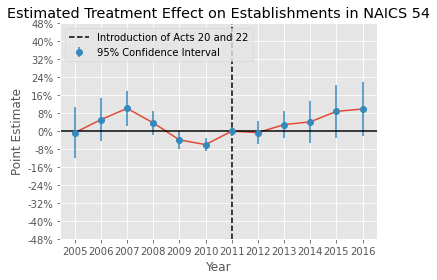

In [43]:
# REGRESSION MODEL

# Define variable of interest: per capita annual avg establishments
y = np.log(service_panel_reg['pc_annual_avg_estabs'])

# Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
# Note that 2011–year prior to the intervention–is not included in the exogenous variables
# This makes all coefficient estimates interpretable as relative to 2011
exog = sm.add_constant(service_panel_reg[['2005_pr', '2006_pr',
       '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
       '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

# Running weighted OLS model
res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                weights=service_panel_reg['weight'],             # Using weights calculated through IPTW
                entity_effects=True, time_effects=True)) # Setting fixed effects

# Fitting model, using clustered standard errors for each county-industry
serv_mod_estab = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)

# Present model results
print(serv_mod_estab)


# PARAMETER MANAGEMENT

# Extract point estimates and save in chronological order
ests = serv_mod_estab.params          # Extract model output
param_list = np.zeros(len(ests))  # Empty list to save correctly ordered estimates
param_list[0:6] = ests[1:7]       # Drop constant and save 2005 - 2010 values
param_list[6] = 0                 # Code 2011 as 0; all coefficients will be interpretable to 2011 levels
param_list[7:] = ests[7:]         # Save 2012 - 2016 values

# Extract 95% confidence intervals for point estimates
ci = (serv_mod_estab.conf_int().reindex(['2005_pr', '2006_pr',                   # Save confidence interval output
                                    '2007_pr', '2008_pr', '2009_pr',      # And re-order to chronological order
                                    '2010_pr', 'const','2012_pr',   
                                    '2013_pr', '2014_pr', '2015_pr',    
                                    '2016_pr']))  
  
lower_error = param_list - np.array(ci['lower'].reset_index(drop=True))   # Calc dist. from param to lower bound
upper_error = np.array(ci['upper'].reset_index(drop=True)) - param_list   # Calc dist. from upper bound to param
errors = [lower_error,upper_error]                                        # Create list with distances for matplotlib


# VISUALIZATION


fig,ax = plt.subplots()                                                   # Create figure and ax
ax.plot(param_list)                                                       # Plot values
ax.errorbar(x=np.arange(len(param_list)),                                 # Provide x tick locations
            y=param_list,                                                 # Provide y values
            yerr=errors, fmt='o',                                         # Provide list with lower and upper bounds
            label='95% Confidence Interval')                              # Provide label 
ax.set_xticks(np.arange(len(ests)))                                       # Provide x tick locations, 0 to 11 values
ax.set_xticklabels(np.arange(2005,2017).astype(str))                      # List of years as strings to be plotted in xtick locations
ax.set_title('Estimated Treatment Effect on Establishments in NAICS 54')  # Set titles and labels            
ax.set_xlabel('Year')
ax.set_ylabel('Point Estimate')
ax.axvline(6,color='k',                                          # Location 6 = Year 2011
           label='Introduction of Acts 20 and 22', ls = '--')
ax.axhline(0,color='k')
ax.set_yticks(np.arange(-.48,.56,0.08))                          # Setting y tick spacing
ax.set_ylim([-.48, .48])                                         # Visualization limits
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1,      # Formatting percentage, xmax=1 means 1 = 100%
                                                    decimals=0)) # Decimals = 0 -> No decimals in format
ax.legend(loc='upper left')                   
fig.set_tight_layout(True)                                       # Visualization cleanliness

##### Wages

                            PanelOLS Estimation Summary                            
Dep. Variable:     pc_total_annual_wages   R-squared:                        0.0148
Estimator:                      PanelOLS   R-squared (Between):             -0.0041
No. Observations:                  16524   R-squared (Within):               0.0334
Date:                   Tue, Dec 14 2021   R-squared (Overall):             -0.0026
Time:                           17:59:22   Log-likelihood                    1362.7
Cov. Estimator:                Clustered                                           
                                           F-statistic:                   2.324e+04
Entities:                           1377   P-value                           0.0000
Avg Obs:                          12.000   Distribution:                F(11,15125)
Min Obs:                          12.000                                           
Max Obs:                          12.000   F-statistic (robust):            

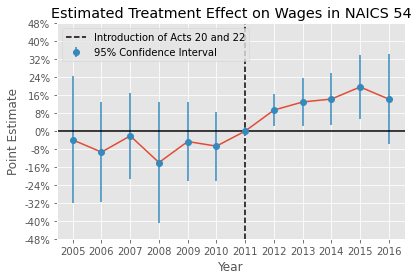

In [44]:
# REGRESSION MODEL

# Define variable of interest: per capita total annual wages
y = np.log(service_panel_reg['pc_total_annual_wages'])

# Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
# Note that 2011–year prior to the intervention–is not included in the exogenous variables
# This makes all coefficient estimates interpretable as relative to 2011
exog = sm.add_constant(service_panel_reg[['2005_pr', '2006_pr',
       '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
       '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

# Running weighted OLS model
res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                weights=service_panel_reg['weight'],             # Using weights calculated through IPTW
                entity_effects=True, time_effects=True)) # Setting fixed effects

# Fitting model, using clustered standard errors for each county-industry
serv_mod_wages = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)

# Present model results
print(serv_mod_wages)


# PARAMETER MANAGEMENT

# Extract point estimates and save in chronological order
ests = serv_mod_wages.params      # Extract model output
param_list = np.zeros(len(ests))  # Empty list to save correctly ordered estimates
param_list[0:6] = ests[1:7]       # Drop constant and save 2005 - 2010 values
param_list[6] = 0                 # Code 2011 as 0; all coefficients will be interpretable to 2011 levels
param_list[7:] = ests[7:]         # Save 2012 - 2016 values

# Extract 95% confidence intervals for point estimates
ci = (serv_mod_wages.conf_int().reindex(['2005_pr', '2006_pr',            # Save confidence interval output
                                    '2007_pr', '2008_pr', '2009_pr',      # And re-order to chronological order
                                    '2010_pr', 'const','2012_pr',   
                                    '2013_pr', '2014_pr', '2015_pr',    
                                    '2016_pr']))  
  
lower_error = param_list - np.array(ci['lower'].reset_index(drop=True))   # Calc dist. from param to lower bound
upper_error = np.array(ci['upper'].reset_index(drop=True)) - param_list   # Calc dist. from upper bound to param
errors = [lower_error,upper_error]                                        # Create list with distances for matplotlib


# VISUALIZATION


fig,ax = plt.subplots()                                           # Create figure and ax
ax.plot(param_list)                                               # Plot values
ax.errorbar(x=np.arange(len(param_list)),                         # Provide x tick locations
            y=param_list,                                         # Provide y values
            yerr=errors, fmt='o',                                 # Provide list with lower and upper bounds
            label='95% Confidence Interval')                      # Provide label 
ax.set_xticks(np.arange(len(ests)))                               # Provide x tick locations, 0 to 11 values
ax.set_xticklabels(np.arange(2005,2017).astype(str))              # List of years as strings to be plotted in xtick locations
ax.set_title('Estimated Treatment Effect on Wages in NAICS 54')   # Set titles and labels            
ax.set_xlabel('Year')
ax.set_ylabel('Point Estimate')
ax.axvline(6,color='k',                                          # Location 6 = Year 2011
           label='Introduction of Acts 20 and 22', ls = '--')
ax.axhline(0,color='k')
ax.set_yticks(np.arange(-.48,.56,0.08))                          # Setting y tick spacing
ax.set_ylim([-.48, .48])                                         # Visualization limits
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1,      # Formatting percentage, xmax=1 means 1 = 100%
                                                    decimals=0)) # Decimals = 0 -> No decimals in format
ax.legend(loc='upper left')                   
fig.set_tight_layout(True)                                       # Visualization cleanliness

#### Model Outputs

In [45]:
print(compare({' ' : serv_mod_emp}, stars=True));
print(compare({' ' : serv_mod_estab}, stars=True));
print(compare({' ' : serv_mod_wages}, stars=True));

                Model Comparison                
                                                
------------------------------------------------
Dep. Variable               pc_annual_avg_emplvl
Estimator                               PanelOLS
No. Observations                           16524
Cov. Est.                              Clustered
R-squared                                 0.0271
R-Squared (Within)                        0.0302
R-Squared (Between)                      -0.0094
R-Squared (Overall)                      -0.0079
F-statistic                            2.269e+04
P-value (F-stat)                          0.0000
=====================     ======================
const                                 -4.6870***
                                       (-1671.2)
2005_pr                                  -0.0634
                                       (-0.6100)
2006_pr                                  -0.0954
                                       (-1.1149)
2007_pr             

### Robustness Checks

#### Varying Growth Rates

In [46]:
# DEFINING FUNCTION TO BE USED

def growth_variation_serv(growth_predictors):
    
    # RESETTING THE DATA
    services_df = copy.deepcopy(services_df_b)
    data_2011_serv = copy.deepcopy(data_2011_serv_b)
    
    # VARYING PREDICTORS FOR THE MATCHING PROCESS

    # Define base predictors
    preds = ['pc_total_annual_wages', 'pc_annual_avg_emplvl', 'pc_annual_avg_estabs']
    
    # Append period-specific predictors, passed into the function 
    preds.extend(growth_predictors)
    
    # MATCHING PROCESS
    
    # Subset predictor data
    x = data_2011_serv[preds]

    # Define outcome of interest - dummy for being in Puerto Rico
    y = data_2011_serv['pr_dummy']

    # Write formula for predictors
    formula = 'pr_dummy ~ '             # Define dependent variable and begin formula
    for p in preds[:-1]:                # Loop through all the predictors, except the last one
        formula = formula + p + ' + '   # Add each predictor except last one to formula
    formula = formula + preds[-1]       # Add remaining predictor (i.e. last one) to the formula

    # Build model         
    m1 = smf.logit(formula=formula, data=data_2011_serv).fit()

    # Matching Model Summary
    match_summ = m1

    # Estimate probability of being in Puerto Rico
    ps = m1.predict(x)

    # Create weights equal to the inverse of the probability of treatment received
    
    data_2011_serv['weight'] = np.zeros(len(ps)) # List to store values

    for i in np.arange(len(ps)):            # Calculating and storing
        if data_2011_serv['pr_dummy'][i] == 1:
            weight = 1/ps[i]
        else:
            weight = 1/(1-ps[i]) 
        data_2011_serv['weight'][i] = weight

    # Winsorize weights array at the 1% and 99% levels
    data_2011_serv['weight'] = mstats.winsorize(data_2011_serv['weight'],0.01)

    # Create weights df
    weights_df = data_2011_serv[['area_fips','weight']]

    # Add 2011 fixed weights to all observations for each area-industry
    services_df = pd.merge(services_df,weights_df,how='left',on=['area_fips'])

    # Create regression panel
    service_panel_reg = services_df.set_index(['area_industry', 'year']) #Set entity and time indeces
    
    # __________________________________________________
    # REGRESSION NO. 1:  PER CAPITA ANNUAL AVG EMPLOYMENT
    
    # Define variable of interest: per capita total annual wages
    y = np.log(service_panel_reg['pc_annual_avg_emplvl'])

    # Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
    # Note that 2011–year prior to the intervention–is not included in the exogenous variables
    # This makes all coefficient estimates interpretable as relative to 2011
    exog = sm.add_constant(service_panel_reg[['2005_pr', '2006_pr',
           '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
           '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

    # Running weighted OLS model
    res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                    weights=service_panel_reg['weight'],             # Using weights calculated through IPTW
                    entity_effects=True, time_effects=True)) # Setting fixed effects

    # Fitting model, using clustered standard errors for each county-industry
    mod = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)
    
    # Save the model summary
    emp_summ = mod
    
    #Create the ordered parameter estimates
    ests = mod.params
    param_list = np.zeros(len(ests))
    param_list[0:6] = ests[1:7]
    param_list[6] = 0
    param_list[7:] = ests[7:]
    emp_params = param_list
    
    # __________________________________________________
    # REGRESSION NO. 2:  PER CAPITA ANNUAL ESTABS
    
    # Define variable of interest: per capita total annual wages
    y = np.log(service_panel_reg['pc_annual_avg_estabs'])

    # Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
    # Note that 2011–year prior to the intervention–is not included in the exogenous variables
    # This makes all coefficient estimates interpretable as relative to 2011
    exog = sm.add_constant(service_panel_reg[['2005_pr', '2006_pr',
           '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
           '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

    # Running weighted OLS model
    res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                    weights=service_panel_reg['weight'],             # Using weights calculated through IPTW
                    entity_effects=True, time_effects=True)) # Setting fixed effects

    # Fitting model, using clustered standard errors for each county-industry
    mod = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)
    
    # Save the model summary
    estabs_summ = mod
    
    #Create the ordered parameter estimates
    ests = mod.params
    param_list = np.zeros(len(ests))
    param_list[0:6] = ests[1:7]
    param_list[6] = 0
    param_list[7:] = ests[7:]
    estabs_params = param_list
    
    # __________________________________________________
    # REGRESSION NO. 3:  PER CAPITA ANNUAL WAGES
    
    # Define variable of interest: per capita total annual wages
    y = np.log(service_panel_reg['pc_total_annual_wages'])

    # Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
    # Note that 2011–year prior to the intervention–is not included in the exogenous variables
    # This makes all coefficient estimates interpretable as relative to 2011
    exog = sm.add_constant(service_panel_reg[['2005_pr', '2006_pr',
           '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
           '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

    # Running weighted OLS model
    res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                    weights=service_panel_reg['weight'],             # Using weights calculated through IPTW
                    entity_effects=True, time_effects=True)) # Setting fixed effects

    # Fitting model, using clustered standard errors for each county-industry
    mod = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)
    
    # Save the model summary
    wages_summ = mod
    
    #Create the ordered parameter estimates
    ests = mod.params
    param_list = np.zeros(len(ests))
    param_list[0:6] = ests[1:7]
    param_list[6] = 0
    param_list[7:] = ests[7:]
    wages_params = param_list
    
    return match_summ, emp_summ, emp_params, estabs_summ, estabs_params, wages_summ, wages_params

In [47]:
# CREATE SET OF PERIOD VARIABLES TO BE USED

g_pds = ['g_2005_2011_', 'g_2007_2011_', 'g_2009_2011_']    # Periods over which to calculate growth rates 
var_list = ['pc_annual_avg_estabs', 'pc_annual_avg_emplvl', # Variables of interest
            'pc_total_annual_wages']

g_pd_l = []                 # List to save period-variable combinations

for p in g_pds:                      # Loop over all the periods
    pd_vars = []                     # List to save variables for this period
    for var in var_list:             # Loop over all variables
        joint = p + var              # Combine period and variable
        pd_vars.append(joint)        # Save period-variable combination into period list
    g_pd_l.append(pd_vars)  # Save period list into yearly predictor set list
    
# PREPARE VISUALIZATIONS MATCHES ON DIFFERENT GROWTH PERIODS

# Prepare lists to save outputs for models matched on different growth rates
match_summ_l_g_serv = []     # Matching model summary
wages_summ_l_g_serv = []     # Wages model summary
wages_params_l_g_serv = []   # Wages model parameters
estabs_summ_l_g_serv = []    # Establishment model summary
estabs_params_l_g_serv = []  # Establishment model parameters
emp_summ_l_g_serv = []       # Employment model summary 
emp_params_l_g_serv = []     # Employment model parameters

# Loop over yearly predictor sets
for yearly_preds in g_pd_l:
    (match_summ, emp_summ, emp_params, estabs_summ,   # Run function and save relevant outputs
     estabs_params, wages_summ, wages_params) =       growth_variation_serv(yearly_preds) 
    
    # Save relevant outputs to lists defined above
    match_summ_l_g_serv.append(match_summ)
    wages_summ_l_g_serv.append(wages_summ)
    wages_params_l_g_serv.append(wages_params)
    estabs_summ_l_g_serv.append(estabs_summ)
    estabs_params_l_g_serv.append(estabs_params)
    emp_summ_l_g_serv.append(emp_summ)
    emp_params_l_g_serv.append(emp_params)

Optimization terminated successfully.
         Current function value: 0.055018
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.055541
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.054621
         Iterations 17


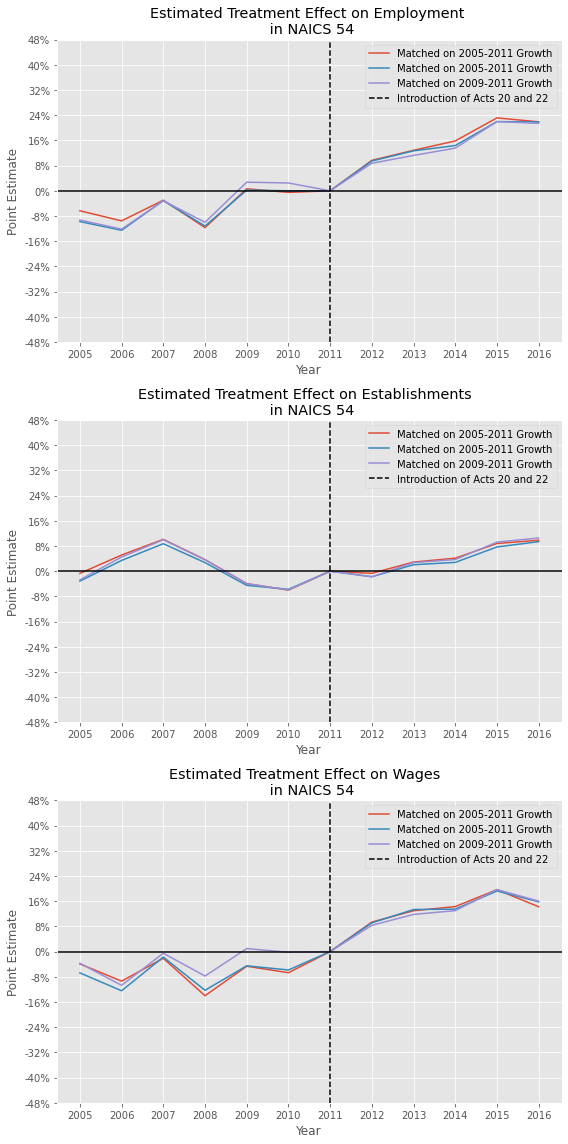

In [48]:
# VISUALIZATIONS FOR ROBUSTNESS CHECKS 

# Define title labels
title_l_g_serv =  ['Estimated Treatment Effect on Employment \n in NAICS 54', 
              'Estimated Treatment Effect on Establishments  \n in NAICS 54',
              'Estimated Treatment Effect on Wages  \n in NAICS 54']

# Define period labels
pd_labels = ['Matched on 2005-2011 Growth',
            'Matched on 2005-2011 Growth',
            'Matched on 2009-2011 Growth']

# Create list of parameters over which to iterate
params_l_o_l_g_serv = [emp_params_l_g_serv, estabs_params_l_g_serv, wages_params_l_g_serv]

# Create matplotlib figure and subplots
fig, ax = plt.subplots(3,1, figsize=(8,16))

# Loop over all parameters of interest 
for i, lists in enumerate(params_l_o_l_g_serv):
    
    # Set title according to parameter of interest
    ax[i].set_title(title_l_g_serv[i])
    
    # Access data for our parameter of interest being plotted
    data = params_l_o_l_g_serv[i]
    
    # Access data for each period and plot
    for p, data in enumerate(data):
        ax[i].plot(data, label = pd_labels[p])
        
    # Formatting x ticks and x label
    ax[i].set_xticks(np.arange(len(ests)))
    ax[i].set_xticklabels(np.arange(2005,2017).astype(str))
    ax[i].set_xlabel('Year')
    
    # Formatting y ticks and y label
    ax[i].set_ylabel('Point Estimate')
    ax[i].set_yticks(np.arange(-.48,.56,0.08))
    ax[i].set_ylim([-.48, .48])
    
    # Adding lines showing: 
    ax[i].axvline(6,color='k', label='Introduction of Acts 20 and 22', ls = '--') # Intervention, 6 = yr 2011
    ax[i].axhline(0,color='k')                                                    # 0 axis
    
    # Formatting y axis: xmax=1 -> 1 = 100%
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    
    # Show legend
    ax[i].legend()
    
# Clean formatting 
fig.set_tight_layout(True)

#### Varying Predictor Sets

In [49]:
# DEFINING FUNCTION
def pred_variation_serv(pred_set):
    """Function takes pred_set, a list of predictors to be used, as an argument."""
    
    # RESETTING THE DATA
    services_df = copy.deepcopy(services_df_b)
    data_2011_serv = copy.deepcopy(data_2011_serv_b)
    
    # VARYING PREDICTORS FOR THE MATCHING PROCESS
    
    # MATCHING PROCESS
    
    # Subset predictor data
    x = data_2011_serv[preds]

    # Define outcome of interest - dummy for being in Puerto Rico
    y = data_2011_serv['pr_dummy']

    # Write formula for predictors
    formula = 'pr_dummy ~ '                # Define dependent variable and begin formula
    for p in pred_set[:-1]:                # Loop through all the predictors, except the last one
        formula = formula + p + ' + '      # Add each predictor except last one to formula
    formula = formula + pred_set[-1]       # Add remaining predictor (i.e. last one) to the formula

    # Build model         
    m1 = smf.logit(formula=formula, data=data_2011_serv).fit()

    # Matching Model Summary
    match_summ = m1

    # Estimate probability of being in Puerto Rico
    ps = m1.predict(x)

    # Create weights equal to the inverse of the probability of treatment received
    
    data_2011_serv['weight'] = np.zeros(len(ps)) # List to store values

    for i in np.arange(len(ps)):            # Calculating and storing
        if data_2011_serv['pr_dummy'][i] == 1:
            weight = 1/ps[i]
        else:
            weight = 1/(1-ps[i]) 
        data_2011_serv['weight'][i] = weight

    # Winsorize weights array at the 1% and 99% levels
    data_2011_serv['weight'] = mstats.winsorize(data_2011_serv['weight'],0.01)

    # Create weights df
    weights_df = data_2011_serv[['area_fips','weight']]

    # Add 2011 fixed weights to all observations for each area-industry
    services_df = pd.merge(services_df,weights_df,how='left',on=['area_fips'])

    # Create regression panel
    service_panel_reg = services_df.set_index(['area_industry', 'time_industry']) #Set entity and time indeces
    
    # __________________________________________________
    # REGRESSION NO. 1:  PER CAPITA ANNUAL AVG EMPLOYMENT
    
    # Define variable of interest: per capita total annual wages
    y = np.log(service_panel_reg['pc_annual_avg_emplvl'])

    # Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
    # Note that 2011–year prior to the intervention–is not included in the exogenous variables
    # This makes all coefficient estimates interpretable as relative to 2011
    exog = sm.add_constant(service_panel_reg[['2005_pr', '2006_pr',
           '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
           '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

    # Running weighted OLS model
    res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                    weights=service_panel_reg['weight'],             # Using weights calculated through IPTW
                    entity_effects=True, time_effects=True)) # Setting fixed effects

    # Fitting model, using clustered standard errors for each county-industry
    mod = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)
    
    # Save the model summary
    emp_summ = mod
    
    #Create the ordered parameter estimates
    ests = mod.params
    param_list = np.zeros(len(ests))
    param_list[0:6] = ests[1:7]
    param_list[6] = 0
    param_list[7:] = ests[7:]
    emp_params = param_list
    
    # __________________________________________________
    # REGRESSION NO. 2:  PER CAPITA ANNUAL ESTABS
    
    # Define variable of interest: per capita total annual wages
    y = np.log(service_panel_reg['pc_annual_avg_estabs'])

    # Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
    # Note that 2011–year prior to the intervention–is not included in the exogenous variables
    # This makes all coefficient estimates interpretable as relative to 2011
    exog = sm.add_constant(service_panel_reg[['2005_pr', '2006_pr',
           '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
           '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

    # Running weighted OLS model
    res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                    weights=service_panel_reg['weight'],             # Using weights calculated through IPTW
                    entity_effects=True, time_effects=True)) # Setting fixed effects

    # Fitting model, using clustered standard errors for each county-industry
    mod = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)
    
    # Save the model summary
    estabs_summ = mod
    
    #Create the ordered parameter estimates
    ests = mod.params
    param_list = np.zeros(len(ests))
    param_list[0:6] = ests[1:7]
    param_list[6] = 0
    param_list[7:] = ests[7:]
    estabs_params = param_list
    
    # __________________________________________________
    # REGRESSION NO. 3:  PER CAPITA ANNUAL WAGES
    
    # Define variable of interest: per capita total annual wages
    y = np.log(service_panel_reg['pc_total_annual_wages'])

    # Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
    # Note that 2011–year prior to the intervention–is not included in the exogenous variables
    # This makes all coefficient estimates interpretable as relative to 2011
    exog = sm.add_constant(service_panel_reg[['2005_pr', '2006_pr',
           '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
           '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

    # Running weighted OLS model
    res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                    weights=service_panel_reg['weight'],             # Using weights calculated through IPTW
                    entity_effects=True, time_effects=True)) # Setting fixed effects

    # Fitting model, using clustered standard errors for each county-industry
    mod = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)
    
    # Save the model summary
    wages_summ = mod
    
    #Create the ordered parameter estimates
    ests = mod.params
    param_list = np.zeros(len(ests))
    param_list[0:6] = ests[1:7]
    param_list[6] = 0
    param_list[7:] = ests[7:]
    wages_params = param_list
    
    return match_summ, emp_summ, emp_params, estabs_summ, estabs_params, wages_summ, wages_params

In [50]:
# Define all predictors
all_preds_serv = ['pc_total_annual_wages', 'pc_annual_avg_emplvl', 'pc_annual_avg_estabs', 
                  'g_2005_2011_pc_annual_avg_estabs','g_2005_2011_pc_annual_avg_emplvl',
                  'g_2005_2011_pc_total_annual_wages']

# Define predictor sets 
pred_set_1_serv = all_preds_serv[0:3]
pred_set_2_serv = all_preds_serv[3:6]

# Pred_set list
pred_set_l_p_serv = [pred_set_1_serv, pred_set_2_serv, all_preds_serv]

#Create empty lists
match_summ_l_p_serv = []
wages_summ_l_p_serv = []
wages_params_l_p_serv = []
estabs_summ_l_p_serv = []
estabs_params_l_p_serv = []
emp_summ_l_p_serv = []
emp_params_l_p_serv = []

# Loop over pred sets
for pred_set in pred_set_l_p_serv:
    (match_summ, wages_summ, wages_params, estabs_summ,        # Save outputs from loop into respective lists
     estabs_params, emp_summ, emp_params) =                    pred_variation_serv(pred_set)
    match_summ_l_p_serv.append(match_summ)
    wages_summ_l_p_serv.append(wages_summ)
    wages_params_l_p_serv.append(wages_params)
    estabs_summ_l_p_serv.append(estabs_summ)
    estabs_params_l_p_serv.append(estabs_params)
    emp_summ_l_p_serv.append(emp_summ)
    emp_params_l_p_serv.append(emp_params)

Optimization terminated successfully.
         Current function value: 0.056887
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.072088
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.055018
         Iterations 19


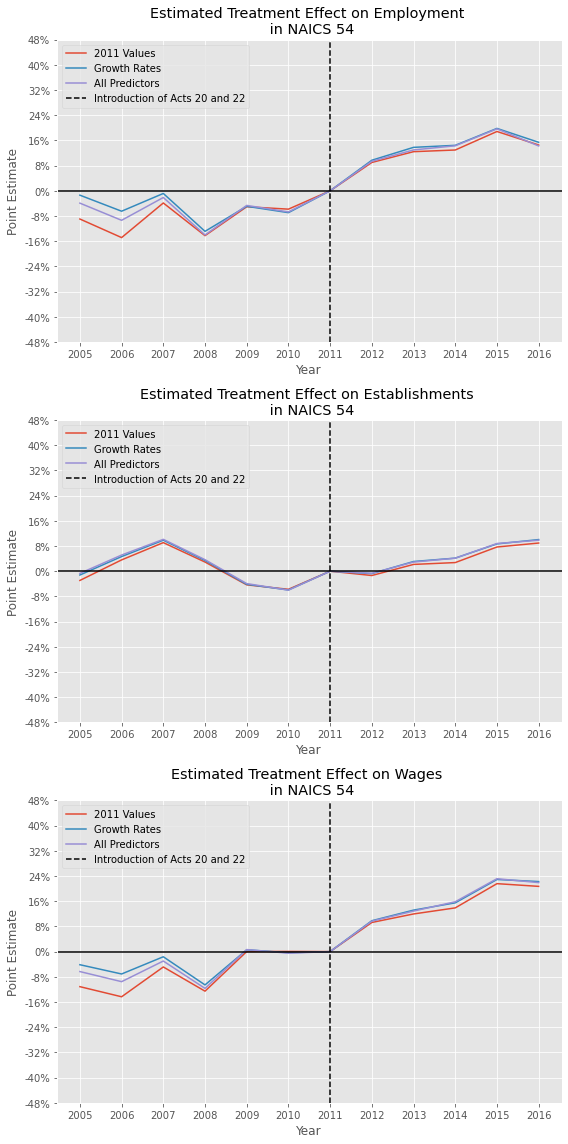

In [51]:
# VISUALIZATIONS FOR ROBUSTNESS CHECKS 

# Define title labels
title_l_g =  ['Estimated Treatment Effect on Employment \n in NAICS 54', 
              'Estimated Treatment Effect on Establishments \n in NAICS 54',
              'Estimated Treatment Effect on Wages \n in NAICS 54']

# Define period labels
pd_labels = ['2011 Values',
            'Growth Rates',
            'All Predictors']

# Create list of parameters over which to iterate
params_l_o_l_p_serv = [emp_params_l_p_serv, estabs_params_l_p_serv, wages_params_l_p_serv]

# Create matplotlib figure and subplots
fig, ax = plt.subplots(3,1, figsize=(8,16))

# Loop over all parameters of interest 
for i, lists in enumerate(params_l_o_l_p_serv):
    
    # Set title according to parameter of interest
    ax[i].set_title(title_l_g[i])
    
    # Access data for our parameter of interest being plotted
    data = params_l_o_l_p_serv[i]
    
    # Access data for each predset and plot
    for p, data in enumerate(data):
        ax[i].plot(data, label = pd_labels[p])
        
    # Formatting x ticks and x label
    ax[i].set_xticks(np.arange(len(ests)))
    ax[i].set_xticklabels(np.arange(2005,2017).astype(str))
    ax[i].set_xlabel('Year')
    
    # Formatting y ticks and y label
    ax[i].set_ylabel('Point Estimate')
    ax[i].set_yticks(np.arange(-.48,.56,0.08))
    ax[i].set_ylim([-.48, .48])
    
    # Adding lines showing: 
    ax[i].axvline(6,color='k', label='Introduction of Acts 20 and 22', ls = '--') # Intervention, 6 = yr 2011
    ax[i].axhline(0,color='k')                                                    # 0 axis
    
    # Formatting y axis: xmax=1 -> 1 = 100%
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    
    # Show legend
    ax[i].legend(loc='upper left')
    
# Clean formatting 
fig.set_tight_layout(True)

#### Varying Winsorization

In [52]:
def winsorization_variation_serv(wins_level):
    """Prior to running this function, run IPTW on the baseline model and save the results in a dataframe
    called data_2011_serv. This will contain original weights. The function will reset a local dataframe and 
    winsorize the original weights. The data is reset every attempt to ensure you do not winsorize
    already-winsorized weights.
    
    wins_level = float between 0 and 1.
    
    Weights will be winsorized at the wins_level and (1 - wins_level) levels. """
    
    # Create unique data set for this winsorization
    data_2011_serv_w = copy.deepcopy(data_2011_serv)                   # Copy of data_2011_serv with original weights
    services_df = copy.deepcopy(services_df_b)
    
    # Winsorize weights array at the x% level
    if wins_level == 0:
        data_2011_serv_w['weight'] = data_2011_serv['weight']
    else:      
        data_2011_serv_w['weight'] = mstats.winsorize(data_2011_serv['weight'],wins_level)

    # Create weights df
    weights_df = data_2011_serv_w[['area_fips','weight']]

    # Add 2011 fixed weights to all observations for each area-industry
    services_df = pd.merge(services_df,weights_df,how='left',on=['area_fips'])

    #Create regression panel
    service_panel_reg = services_df.set_index(['area_industry', 'time_industry']) #Set entity and time indeces
    
    # __________________________________________________
    # REGRESSION NO. 1:  PER CAPITA ANNUAL AVG EMPLOYMENT
    
    # Define variable of interest: per capita total annual wages
    y = np.log(service_panel_reg['pc_annual_avg_emplvl'])

    # Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
    # Note that 2011–year prior to the intervention–is not included in the exogenous variables
    # This makes all coefficient estimates interpretable as relative to 2011
    exog = sm.add_constant(service_panel_reg[['2005_pr', '2006_pr',
           '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
           '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

    # Running weighted OLS model
    res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                    weights=service_panel_reg['weight'],             # Using weights calculated through IPTW
                    entity_effects=True, time_effects=True)) # Setting fixed effects

    # Fitting model, using clustered standard errors for each county-industry
    mod = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)
    
    # Save the model summary
    emp_summ = mod
    
    #Create the ordered parameter estimates
    ests = mod.params
    param_list = np.zeros(len(ests))
    param_list[0:6] = ests[1:7]
    param_list[6] = 0
    param_list[7:] = ests[7:]
    emp_params = param_list
    
    # __________________________________________________
    # REGRESSION NO. 2:  PER CAPITA ANNUAL ESTABS
    
    # Define variable of interest: per capita total annual wages
    y = np.log(service_panel_reg['pc_annual_avg_estabs'])

    # Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
    # Note that 2011–year prior to the intervention–is not included in the exogenous variables
    # This makes all coefficient estimates interpretable as relative to 2011
    exog = sm.add_constant(service_panel_reg[['2005_pr', '2006_pr',
           '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
           '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

    # Running weighted OLS model
    res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                    weights=service_panel_reg['weight'],             # Using weights calculated through IPTW
                    entity_effects=True, time_effects=True)) # Setting fixed effects

    # Fitting model, using clustered standard errors for each county-industry
    mod = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)
    
    # Save the model summary
    estabs_summ = mod
    
    #Create the ordered parameter estimates
    ests = mod.params
    param_list = np.zeros(len(ests))
    param_list[0:6] = ests[1:7]
    param_list[6] = 0
    param_list[7:] = ests[7:]
    estabs_params = param_list
    
    # __________________________________________________
    # REGRESSION NO. 3:  PER CAPITA ANNUAL WAGES
    
    # Define variable of interest: per capita total annual wages
    y = np.log(service_panel_reg['pc_total_annual_wages'])

    # Define exogenous variables (interaction term between year dummy and PR dummy) and add constant
    # Note that 2011–year prior to the intervention–is not included in the exogenous variables
    # This makes all coefficient estimates interpretable as relative to 2011
    exog = sm.add_constant(service_panel_reg[['2005_pr', '2006_pr',
           '2007_pr', '2008_pr', '2009_pr', '2010_pr', '2012_pr',
           '2013_pr', '2014_pr', '2015_pr', '2016_pr']])

    # Running weighted OLS model
    res = (PanelOLS(y, exog,                                 # Define independent and dependent variables
                    weights=service_panel_reg['weight'],             # Using weights calculated through IPTW
                    entity_effects=True, time_effects=True)) # Setting fixed effects

    # Fitting model, using clustered standard errors for each county-industry
    mod = res.fit(cov_type='clustered', cluster_entity=True, cluster_time=False, low_memory=True)
    
    # Save the model summary
    wages_summ = mod
    
    #Create the ordered parameter estimates
    ests = mod.params
    param_list = np.zeros(len(ests))
    param_list[0:6] = ests[1:7]
    param_list[6] = 0
    param_list[7:] = ests[7:]
    wages_params = param_list
    
    return match_summ, emp_summ, emp_params, estabs_summ, estabs_params, wages_summ, wages_params

In [53]:
# Subset data for this attempt
services_df = copy.deepcopy(services_df_b)

# Grab 2011 data
data_2011_serv = services_df.query('year == 2011').reset_index(drop=True)

#Define predictors
preds = ['pc_total_annual_wages', 'pc_annual_avg_emplvl', 'pc_annual_avg_estabs', 'g_2005_2011_pc_annual_avg_estabs','g_2005_2011_pc_annual_avg_emplvl','g_2005_2011_pc_total_annual_wages']

#Subset predictor data
x = data_2011_serv[preds]

#Define outcomes
y = data_2011_serv['pr_dummy']

#Write formula for predictors
formula = 'pr_dummy ~ '
for p in preds[:-1]:
    formula = formula + p + ' + '
formula = formula + preds[-1]   
              
#Build model         
m1 = smf.logit(formula=formula, data=data_2011_serv).fit()

#Print results for model
print(m1.summary())

#Create propensity scores for weights
ps = m1.predict(x)

#Create weights
data_2011_serv['weight'] = np.zeros(len(ps))

for i in np.arange(len(ps)):
    if data_2011_serv['pr_dummy'][i] == 1:
        weight = 1/ps[i]
    else:
        weight = 1/(1-ps[i]) 
    data_2011_serv['weight'][i] = weight

Optimization terminated successfully.
         Current function value: 0.055018
         Iterations 19
                           Logit Regression Results                           
Dep. Variable:               pr_dummy   No. Observations:                 1377
Model:                          Logit   Df Residuals:                     1370
Method:                           MLE   Df Model:                            6
Date:                Tue, 14 Dec 2021   Pseudo R-squ.:                  0.2750
Time:                        17:59:35   Log-Likelihood:                -75.760
converged:                       True   LL-Null:                       -104.49
Covariance Type:            nonrobust   LLR p-value:                 1.471e-10
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.4355      0.655     -

In [54]:
# Define Winsorization Levels
wins_level_l = [0,0.01, 0.025]

#Create empty lists to save output
match_summ_l_w_serv = []
wages_summ_l_w_serv = []
wages_params_l_w_serv = []
estabs_summ_l_w_serv = []
estabs_params_l_w_serv = []
emp_summ_l_w_serv = []
emp_params_l_w_serv = []

# Loop over winsorization levels list
for wins_level in wins_level_l:
    (match_summ, emp_summ, emp_params, estabs_summ,   # Run function and save relevant outputs
     estabs_params, wages_summ, wages_params) =       winsorization_variation_serv(wins_level) 
    
    # Save relevant outputs to lists defined above
    match_summ_l_w_serv.append(match_summ)
    wages_summ_l_w_serv.append(wages_summ)
    wages_params_l_w_serv.append(wages_params)
    estabs_summ_l_w_serv.append(estabs_summ)
    estabs_params_l_w_serv.append(estabs_params)
    emp_summ_l_w_serv.append(emp_summ)
    emp_params_l_w_serv.append(emp_params)

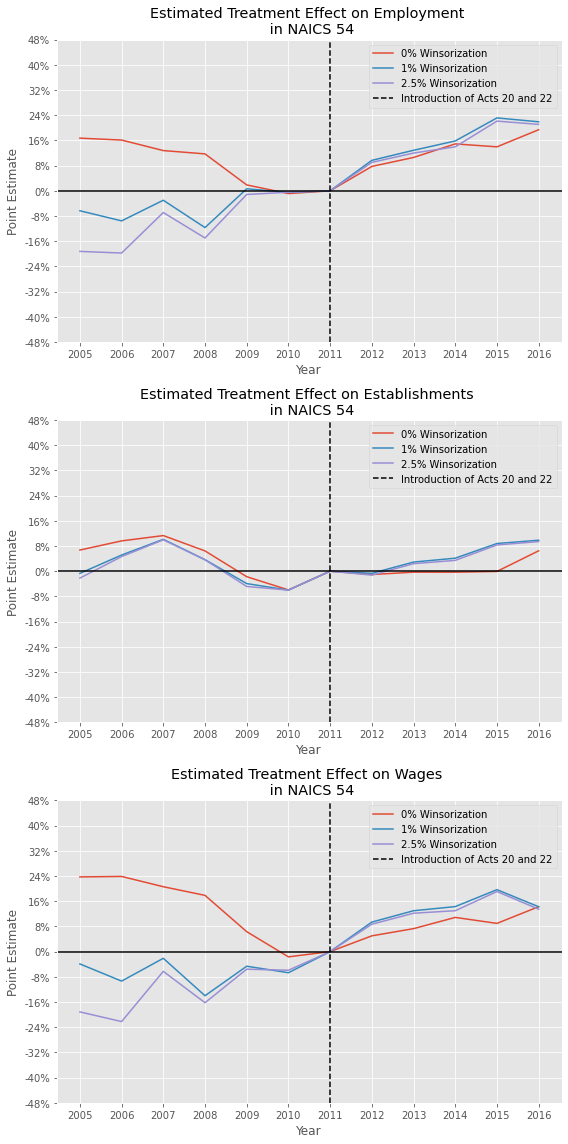

In [55]:
# VISUALIZATIONS FOR ROBUSTNESS CHECKS 

# Define title labels
title_l_g =  ['Estimated Treatment Effect on Employment \n in NAICS 54', 
              'Estimated Treatment Effect on Establishments \n in NAICS 54',
              'Estimated Treatment Effect on Wages \n in NAICS 54']

# Define period labels
w_labels = ['0% Winsorization',
           '1% Winsorization',
           '2.5% Winsorization']

# Create list of parameters over which to iterate
params_l_o_l_w_serv = [emp_params_l_w_serv, estabs_params_l_w_serv, wages_params_l_w_serv]

# Create matplotlib figure and subplots
fig, ax = plt.subplots(3,1, figsize=(8,16))

# Loop over all parameters of interest 
for i, l in enumerate(params_l_o_l_w_serv):
    
    # Set title according to parameter of interest
    ax[i].set_title(title_l_g[i])
    
    # Access data for our parameter of interest being plotted
    data = l
    
    # Access data for each wins_level and plot
    for p, datum in enumerate(data):
        ax[i].plot(datum, label = w_labels[p])
        
    # Formatting x ticks and x label
    ax[i].set_xticks(np.arange(len(ests)))
    ax[i].set_xticklabels(np.arange(2005,2017).astype(str))
    ax[i].set_xlabel('Year')
    
    # Formatting y ticks and y label
    ax[i].set_ylabel('Point Estimate')
    ax[i].set_yticks(np.arange(-.48,.56,0.08))
    ax[i].set_ylim([-.48, .48])
    
    # Adding lines showing: 
    ax[i].axvline(6,color='k', label='Introduction of Acts 20 and 22', ls = '--') # Intervention, 6 = yr 2011
    ax[i].axhline(0,color='k')                                                    # 0 axis
    
    # Formatting y axis: xmax=1 -> 1 = 100%
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    
    # Show legend
    ax[i].legend()
    
# Clean formatting 
fig.set_tight_layout(True)